In [220]:
import warnings
warnings.filterwarnings('ignore') 

from matplotlib import pyplot as plt 
plt.style.use("matplotlib.rc")
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern
import numpy as np

from copy import deepcopy



In [246]:
def get_posterior_mean_and_std(x, model):
    posterior_mean, posterior_std = np.squeeze(model.predict(x, return_std = True))
    return posterior_mean, posterior_std

def calculate_entropy(x, model):
    posterior_mean, posterior_std = get_posterior_mean_and_std(x, model)
    entropy = 0.5 * np.log(2 * np.pi * (posterior_std ** 2)) + 0.5
    return entropy
    

In [239]:
def infobax_gp(x_domain, x_train, y_train, model, algorithm, n_posterior_samples = 20):
    
    gpr_model = deepcopy(model)
    gpr_model.fit(x_train, y_train)    

    term1 = calculate_entropy(x_domain, gpr_model)
    term2 = np.zeros(term1.shape)

    posterior_samples = gpr_model.sample_y(x_domain, n_posterior_samples)    

    for i in range(n_posterior_samples):
        gpr_model_fake = deepcopy(model)
        posterior_sample = np.squeeze(posterior_samples[:, i])              
        desired_indices = algorithm.identify_subspace(posterior_sample, x_domain)

        if len(desired_indices) != 0:
            desired_x = x_domain[desired_indices]  
            predicted_desired_y = posterior_sample[desired_indices]

            fake_x_train = np.vstack((x_train, desired_x))      
            fake_y_train = np.vstack((y_train, np.expand_dims(predicted_desired_y, axis=-1)))
        else:
            fake_x_train = x_train
            fake_y_train = y_train

        gpr_model_fake.fit(fake_x_train, fake_y_train)

        term2 += calculate_entropy(x_domain, gpr_model_fake)

    acquisition_values += term1 -(1/n_posterior_samples) * term2

    return acquisition_values, gpr_model_list


In [253]:
def fn(x, noise = False, noise_threshold = 0.001):
    y =  (1/15) * (-(x-1)*(x/2-2)*(x/2+1)*(x+2))
    return y

def fn2(x, noise = False, noise_threshold = 0.001):
    y =  -(1/30) * (-(x-1)*(x/2-2)*(x/2+1)*(x+2))
    return y

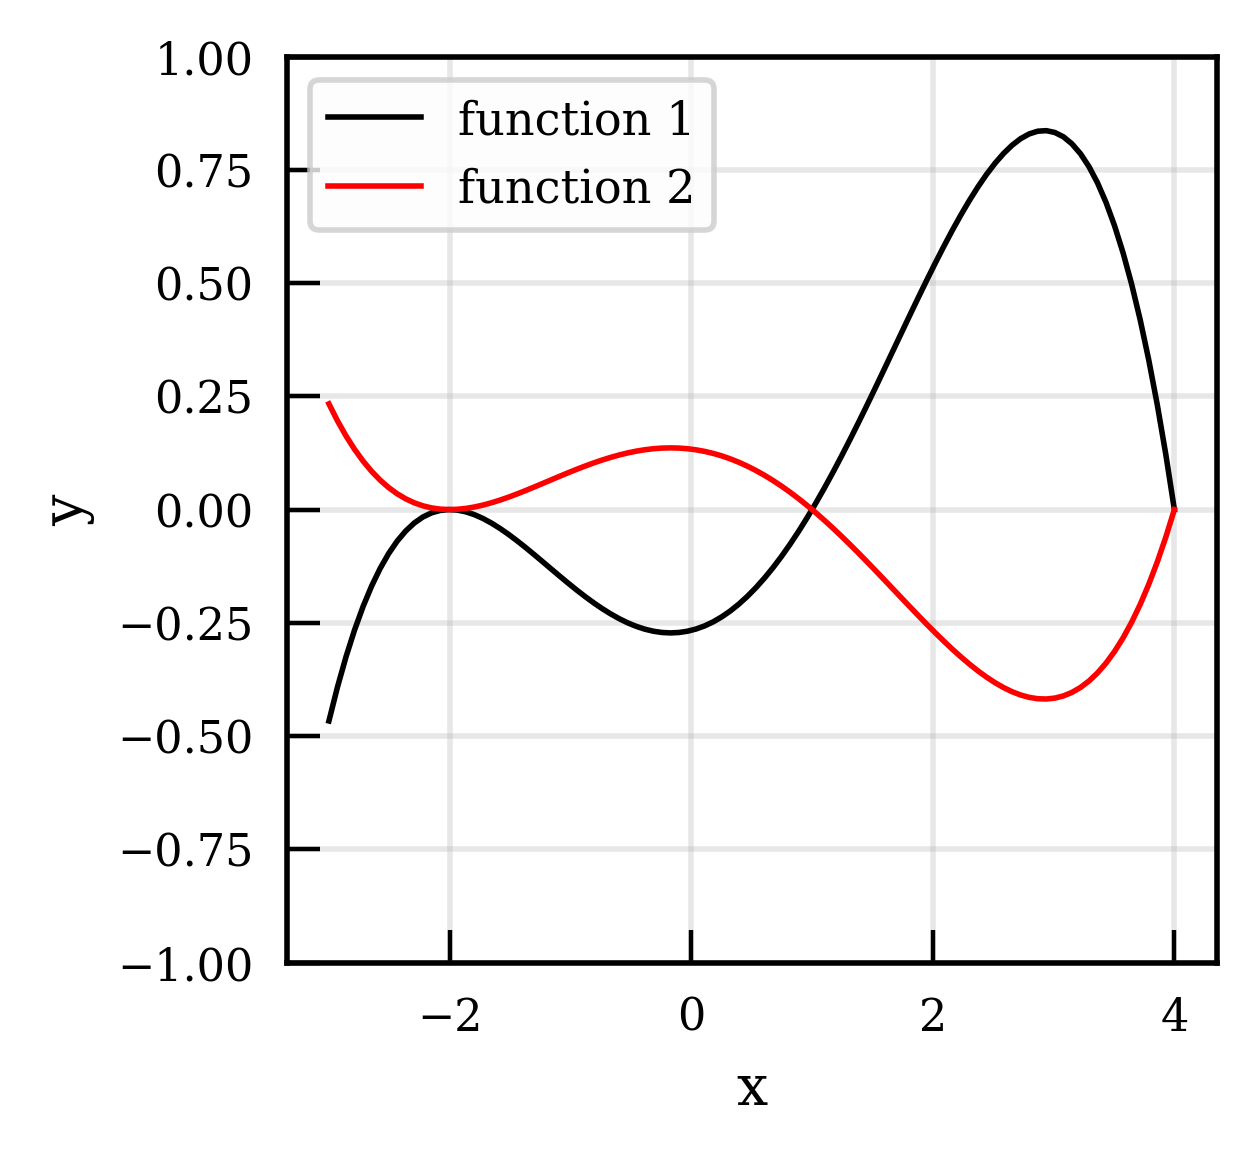

In [257]:
x = np.expand_dims(np.linspace(-3, 4, 100), axis = -1)
plt.figure(figsize=(3,3))
plt.plot(x, fn(x, noise = False), color = 'black', linewidth = 1.0, label = 'function 1')
plt.plot(x, fn2(x, noise = False), color = 'r', linewidth = 1.0, label = 'function 2')
plt.xlabel('x')
plt.ylabel('y')
all_indices = np.arange(0, len(x))
plt.legend()
plt.ylim(-1, 1)
plt.show()

In [258]:
from abc import ABC, abstractmethod

class SubspaceAlgorithm(ABC):
    @abstractmethod
    def identify_subspace(y_vals, x_vals):
        pass
    
class BottomTopPercentile(SubspaceAlgorithm):
    
    def __init__(self, percentile_threshold):
        self.percentile_threshold = percentile_threshold
        
    def identify_subspace(self, y_vals, x_vals):
        percentile_threshold = self.percentile_threshold
        y_90 = np.percentile(y_vals, percentile_threshold)
        y_10 = np.percentile(y_vals, 100 - percentile_threshold)
        ids1 = np.where(y_vals >= y_90)[0]
        ids2 = np.where(y_vals <= y_10)[0]
        
        return list(set(ids1).union(set(ids2)))
    
class LevelBand(SubspaceAlgorithm):
    
    def __init__(self, threshold_list):
        self.threshold_list = threshold_list

    def identify_subspace(self, y_vals, x_vals):
        y_vals = np.array(y_vals)
        ids1 = list(set(np.where(y_vals >= self.threshold_list[0])[0]))
        ids2 = list(set(np.where(y_vals <= self.threshold_list[1])[0]))
        return list(set(ids1).intersection(set(ids2)))
    
class DoubleLevelBand(SubspaceAlgorithm):
    
    def __init__(self, threshold_lists):
        self.threshold_lists = threshold_lists

    def identify_subspace(self, y_vals, x_vals):
        y_vals = np.array(y_vals)
        ids1 = list(set(np.where(y_vals >= self.threshold_lists[0][0])[0]))
        ids2 = list(set(np.where(y_vals <= self.threshold_lists[0][1])[0]))
        
        
        ids3 = list(set(np.where(y_vals >= self.threshold_lists[1][0])[0]))
        ids4 = list(set(np.where(y_vals <= self.threshold_lists[1][1])[0]))
        
        return list(set(ids1).intersection(set(ids2)).union(set(ids3).intersection(set(ids4))))
    
class XDependentLevelBand(SubspaceAlgorithm):
    
    def __init__(self, threshold_lists, x_condition):
        self.threshold_lists = threshold_lists
        self.x_condition = x_condition
        
    def identify_subspace(self, y_vals, x_vals):
        y_vals = np.array(y_vals)
        
        idsCondition = set(np.where(x_vals > self.x_condition)[0])
        ids1 = list(set(np.where(y_vals >= self.threshold_lists[0][0])[0]))
        ids2 = list(set(np.where(y_vals <= self.threshold_lists[0][1])[0]))
        
        intersection1 = set(ids1).intersection(set(ids2)).intersection(idsCondition)
                               
        idsNotCondition = set(np.where(x_vals < self.x_condition)[0])
        ids3 = list(set(np.where(y_vals >= self.threshold_lists[1][0])[0]))
        ids4 = list(set(np.where(y_vals <= self.threshold_lists[1][1])[0]))
        
        intersection2 = set(ids3).intersection(set(ids4)).intersection(idsNotCondition)
                         
                         
        return list(intersection1.union(intersection2))


In [243]:
# algo = LevelBand(threshold_list = [0.5, 0.70])
# algo = DoubleLevelBand(threshold_lists = [[-0.5, -0.25], [0.7,  1.0]])
# algo = XDependentLevelBand(threshold_lists = [[0.6,  1.0],[-0.5, -0.25]], x_condition = 3)
algo = BottomTopPercentile(percentile_threshold = 90)

In [263]:
np.random.seed(10)

all_ids = list(np.arange(0, len(fn(x))))
true_target_ids = algo.identify_subspace(fn(x), x)
true_not_target_ids = list(set(all_ids) - set(true_target_ids))

train_indices = list(np.random.choice(all_indices, 3))
x_train = x[train_indices]
y_train = np.hstack((fn(x_train), fn2(x_train)))


In [266]:
y_train.shape

(3, 2)

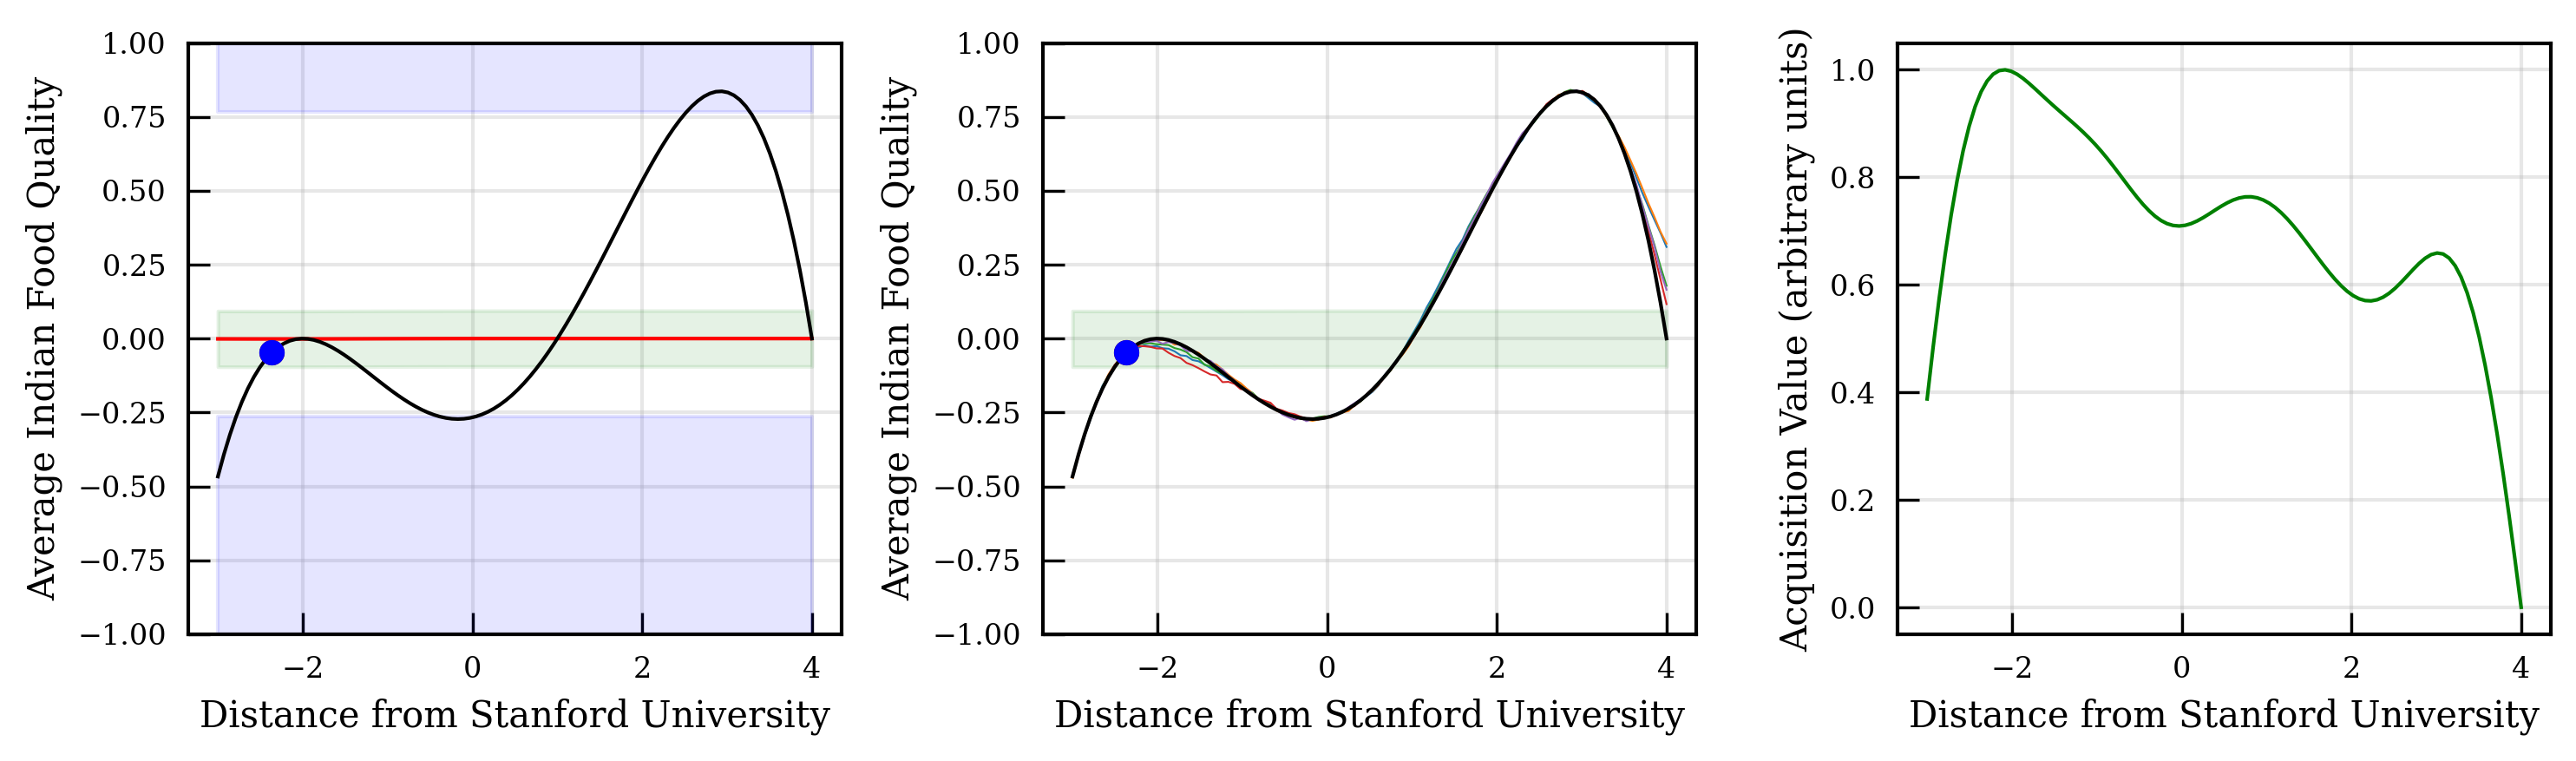

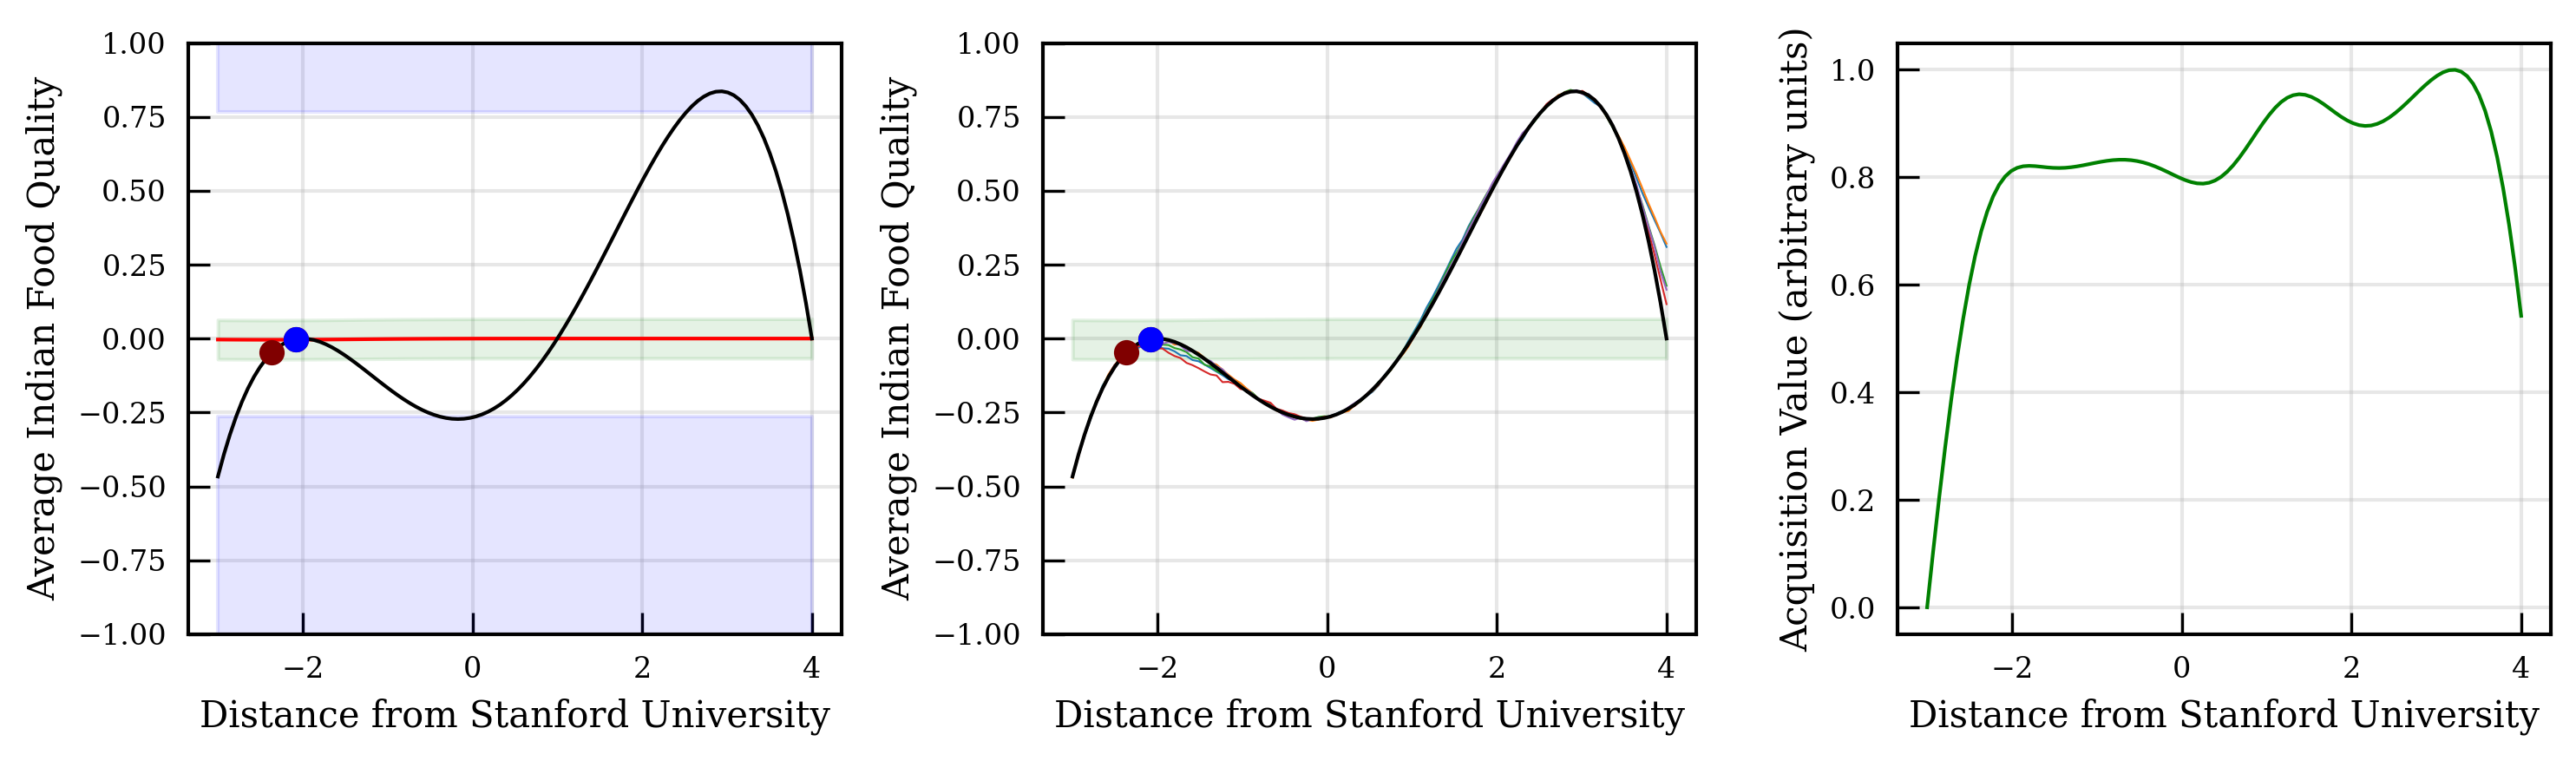

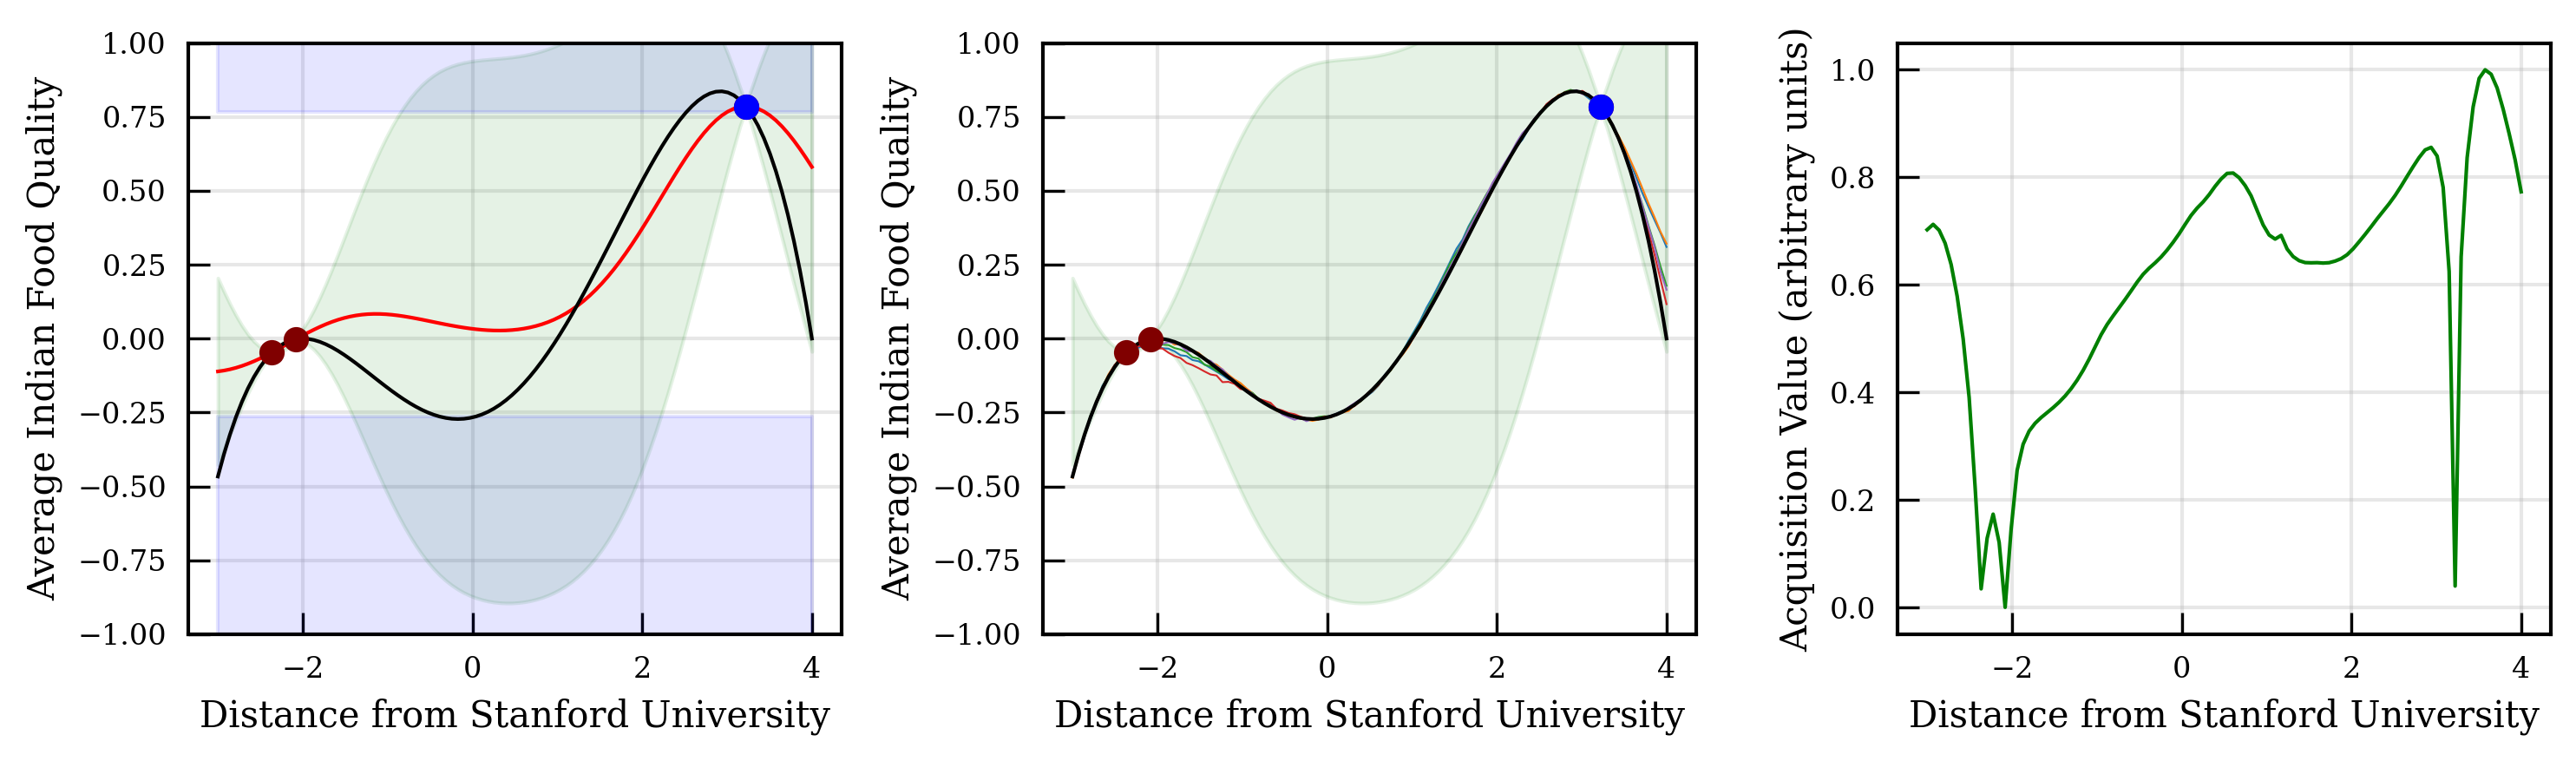

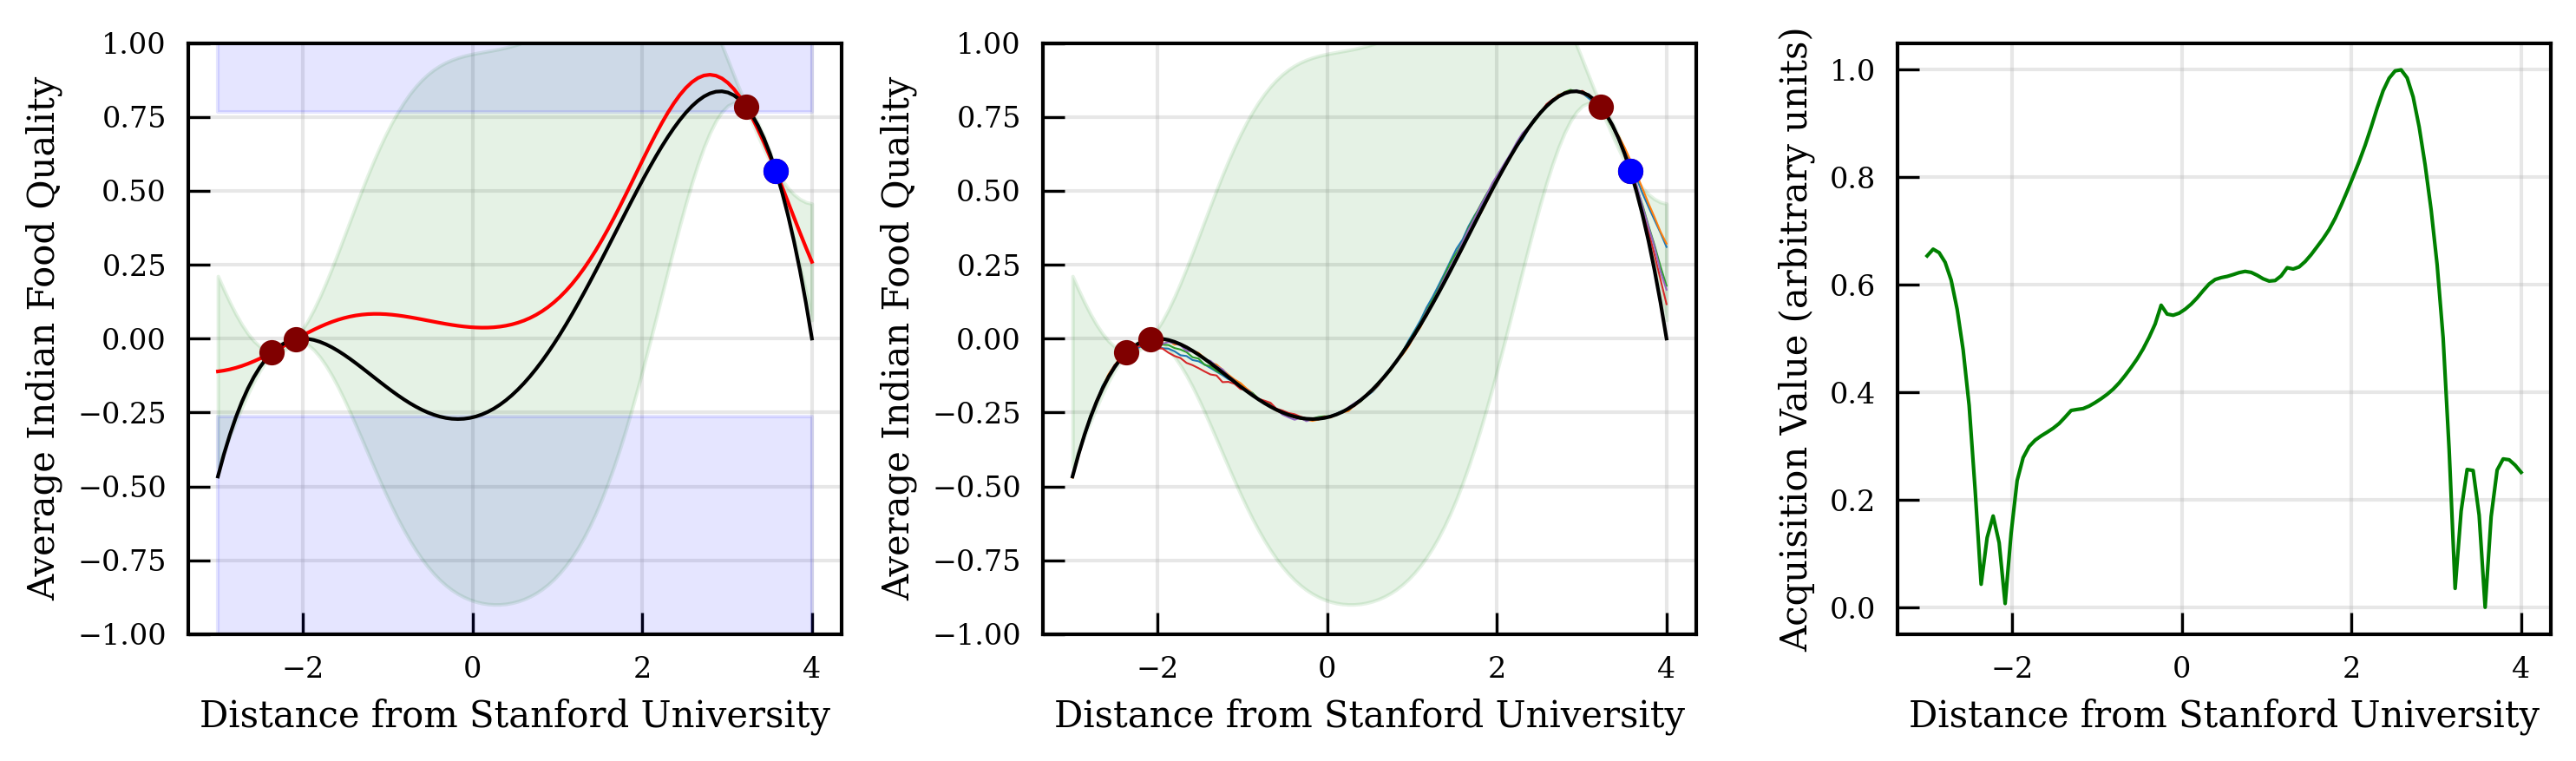

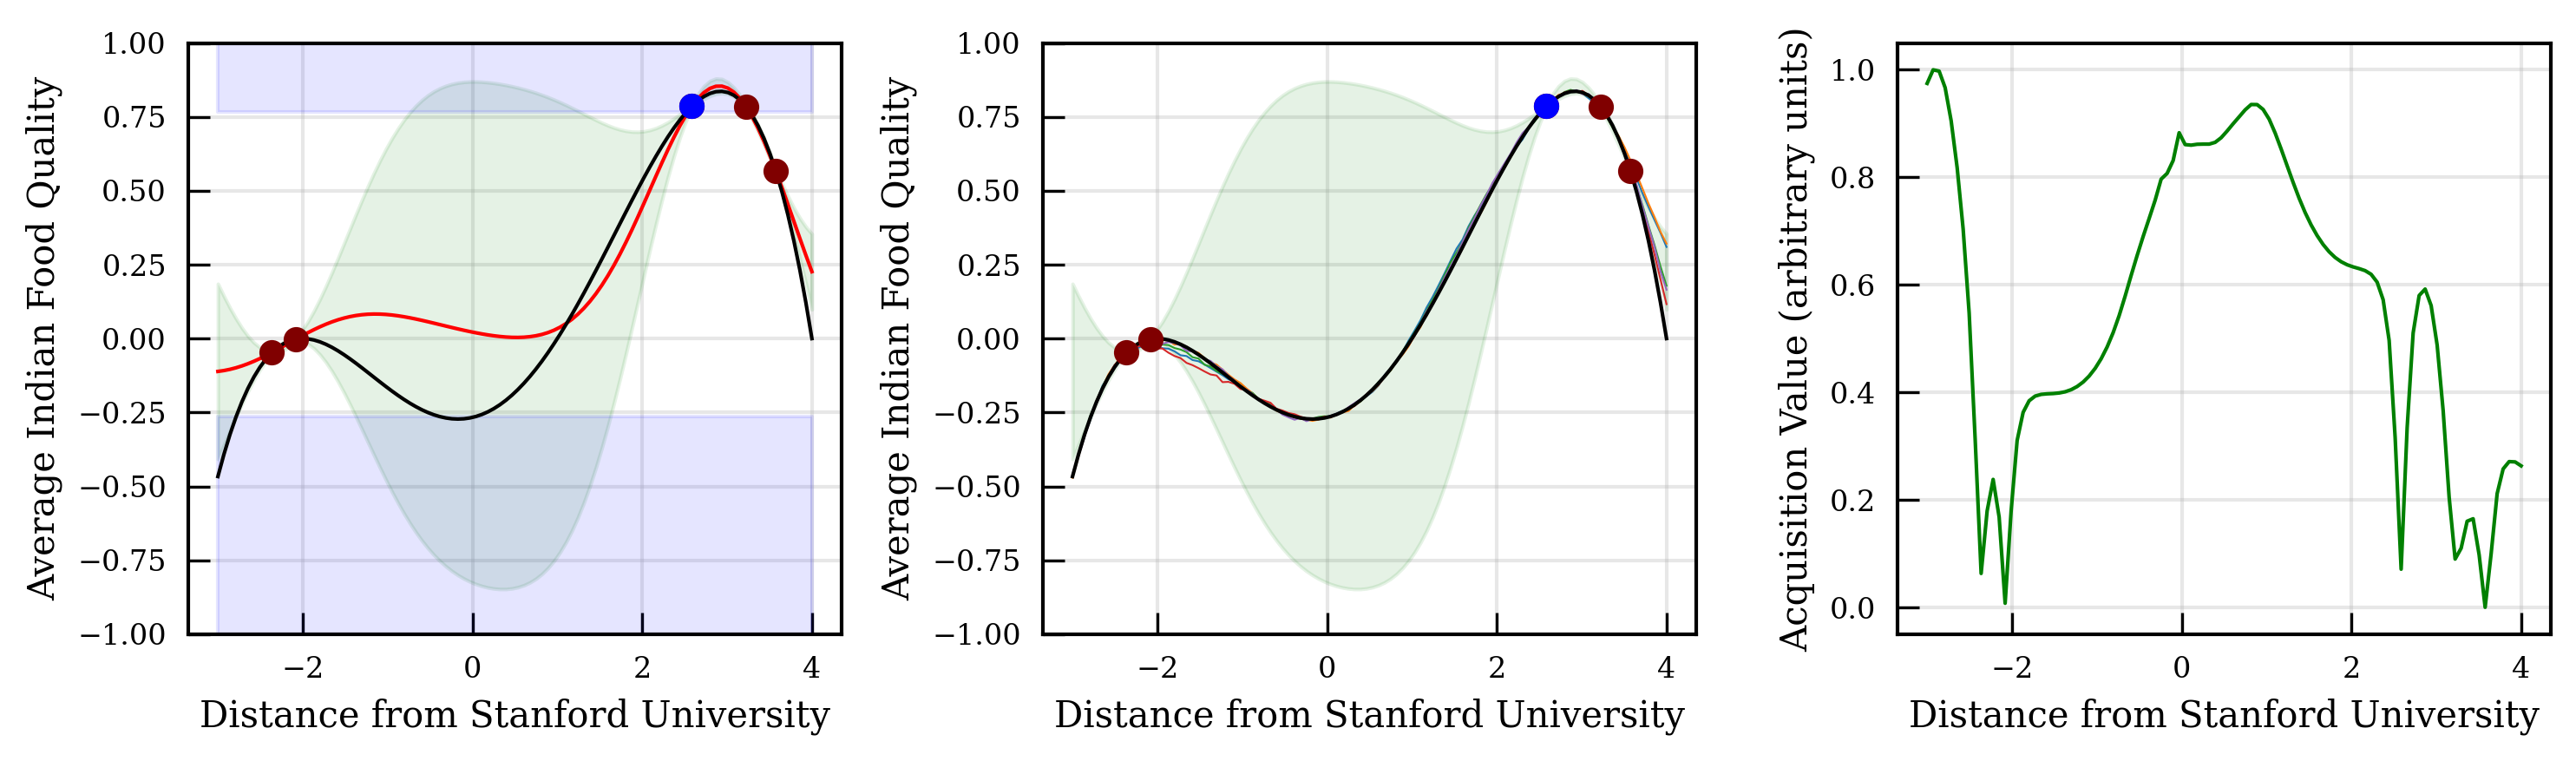

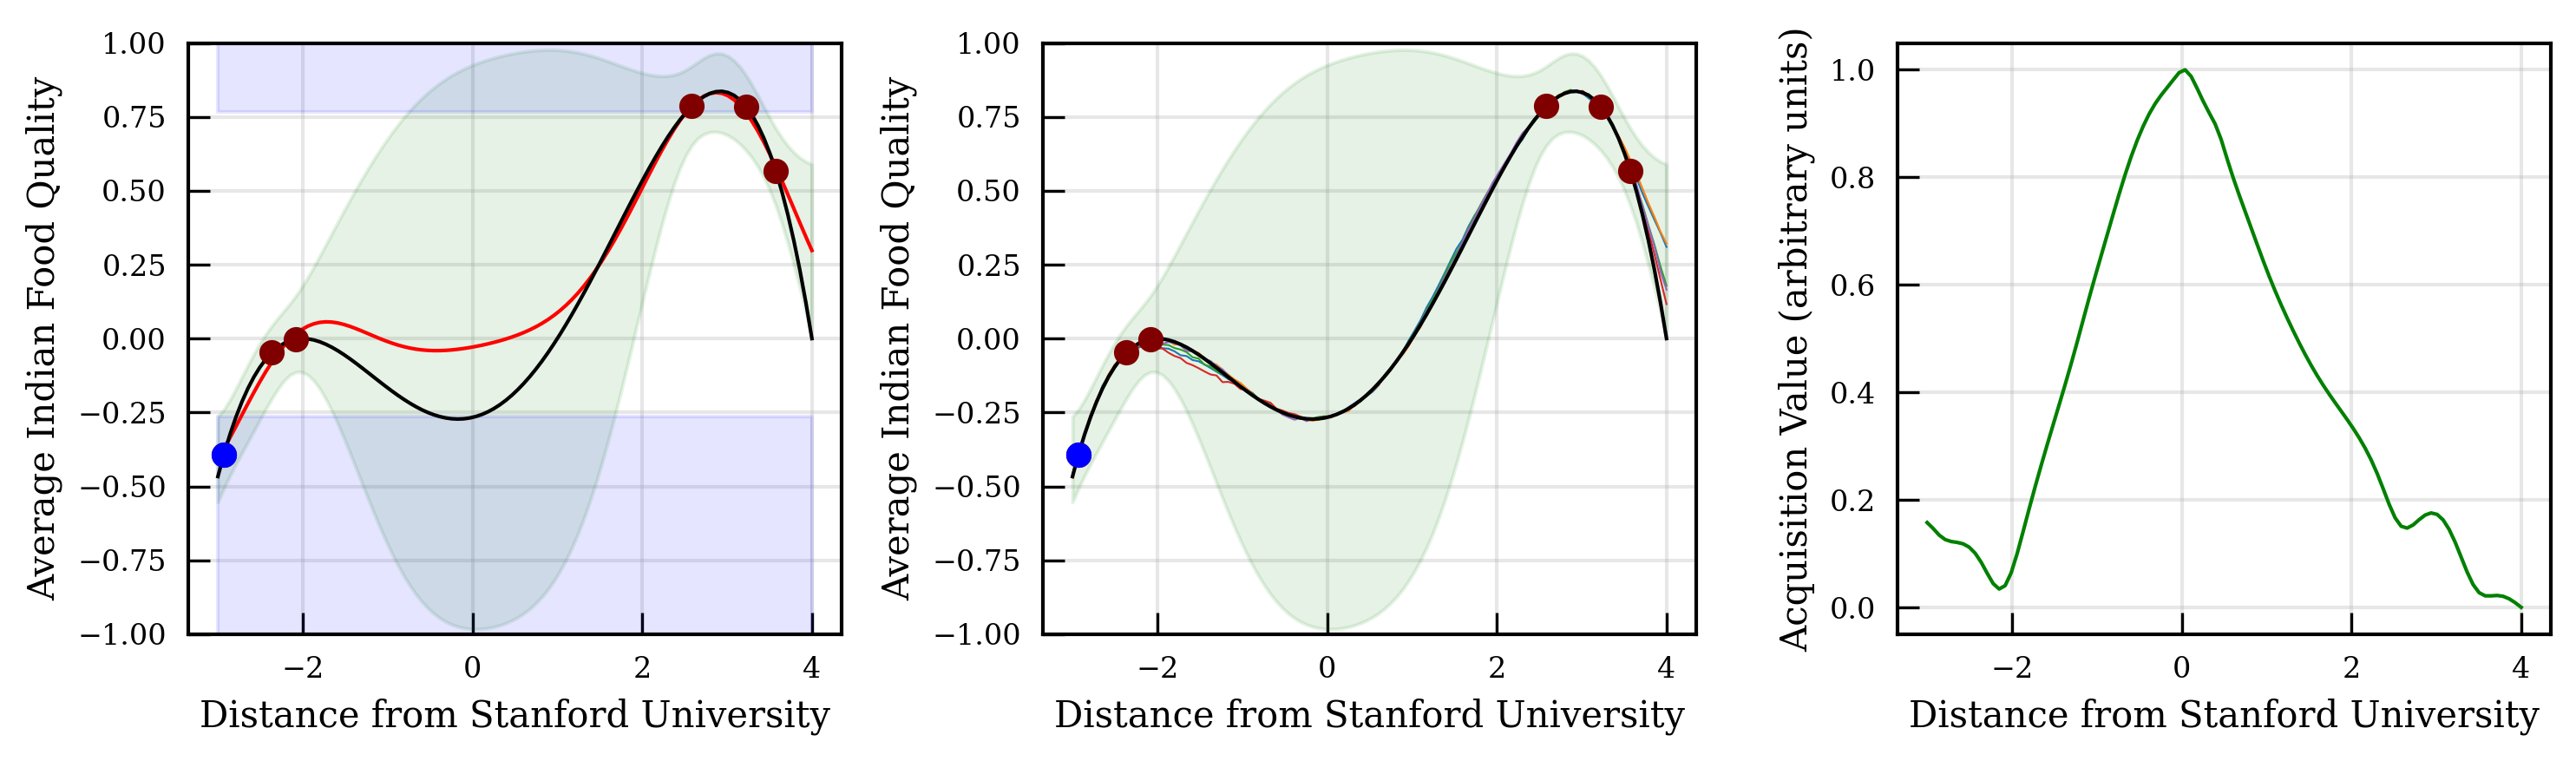

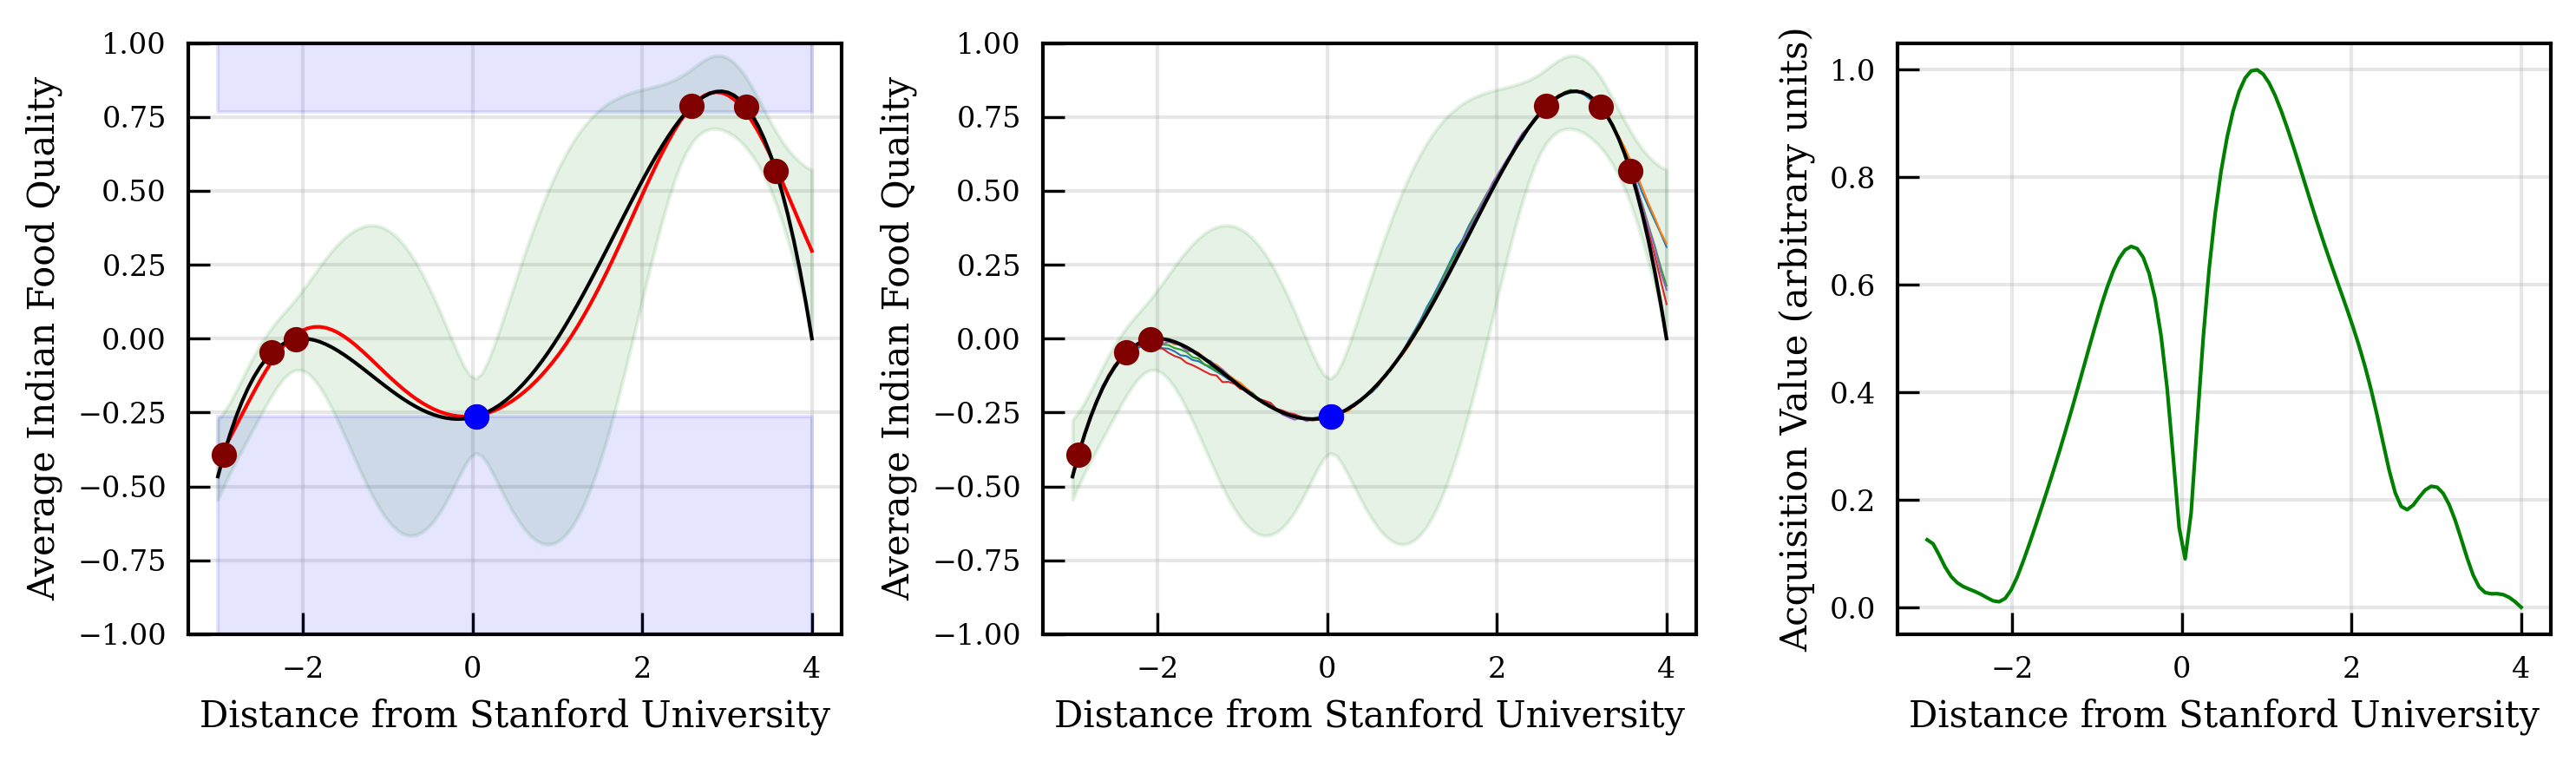

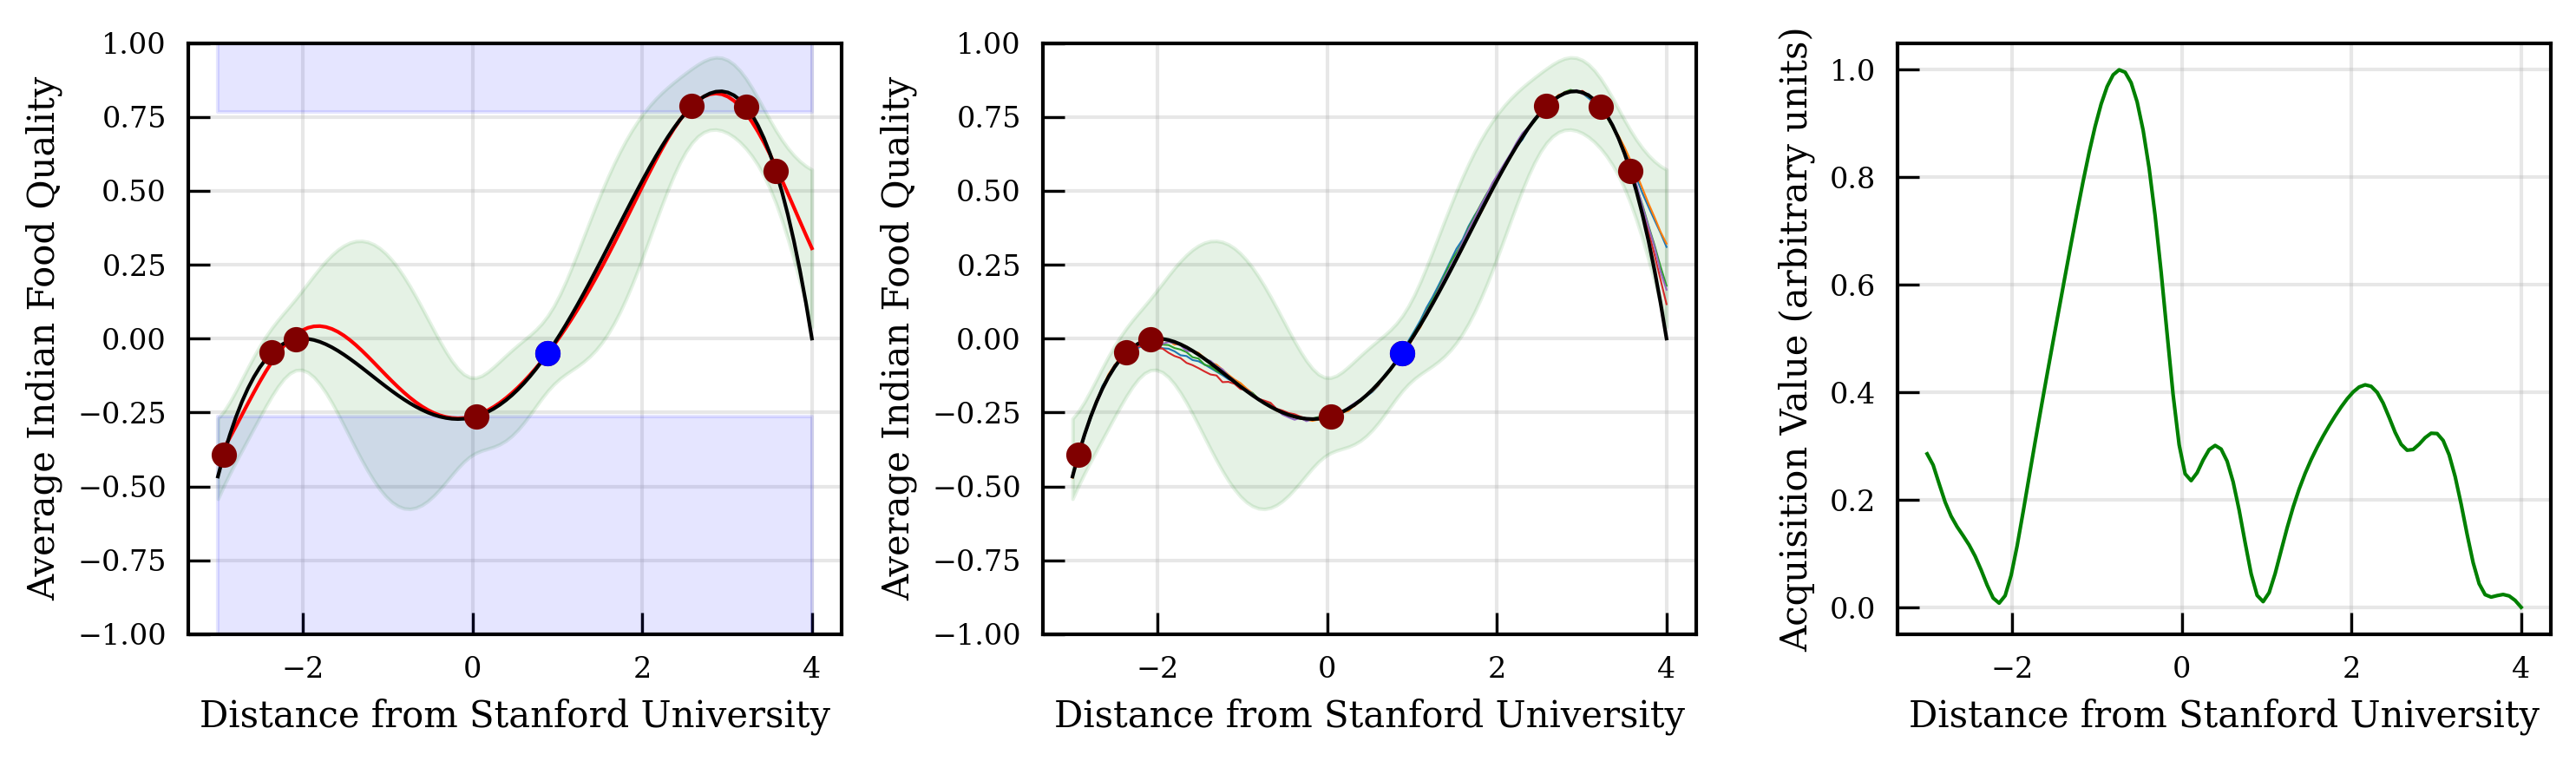

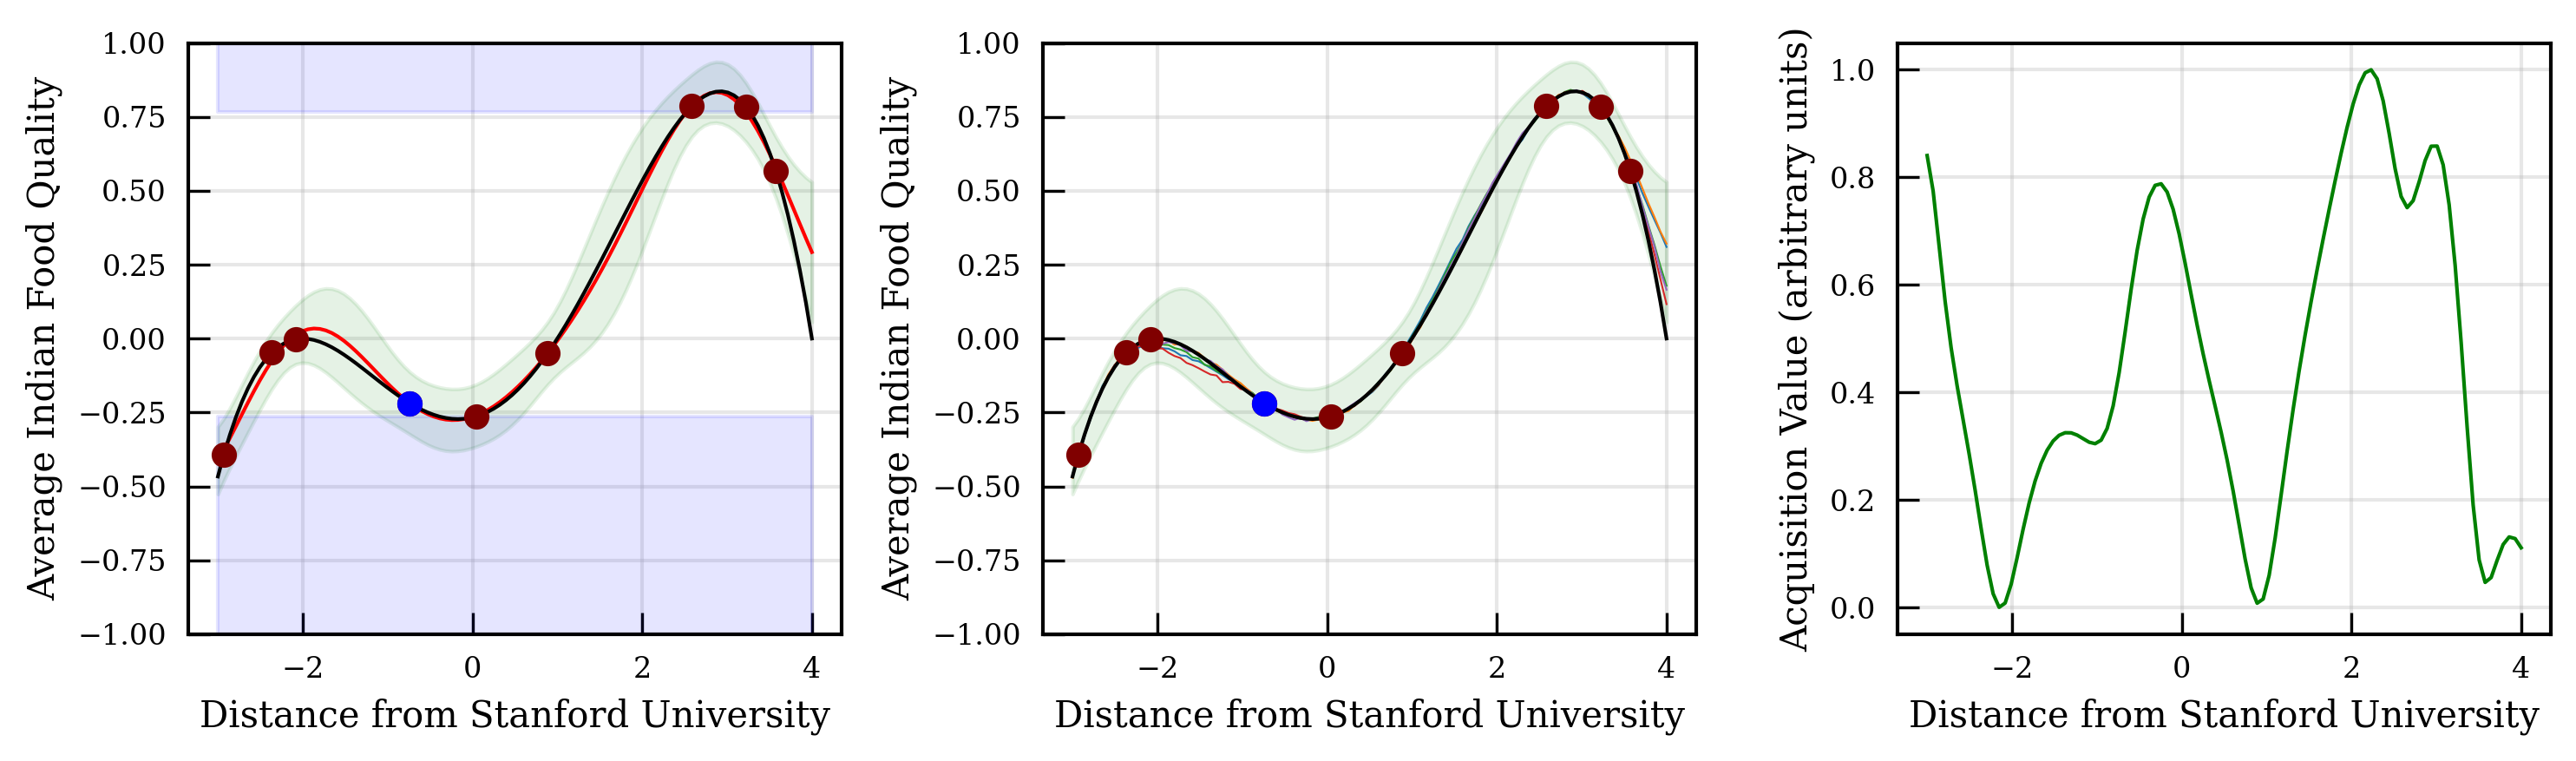

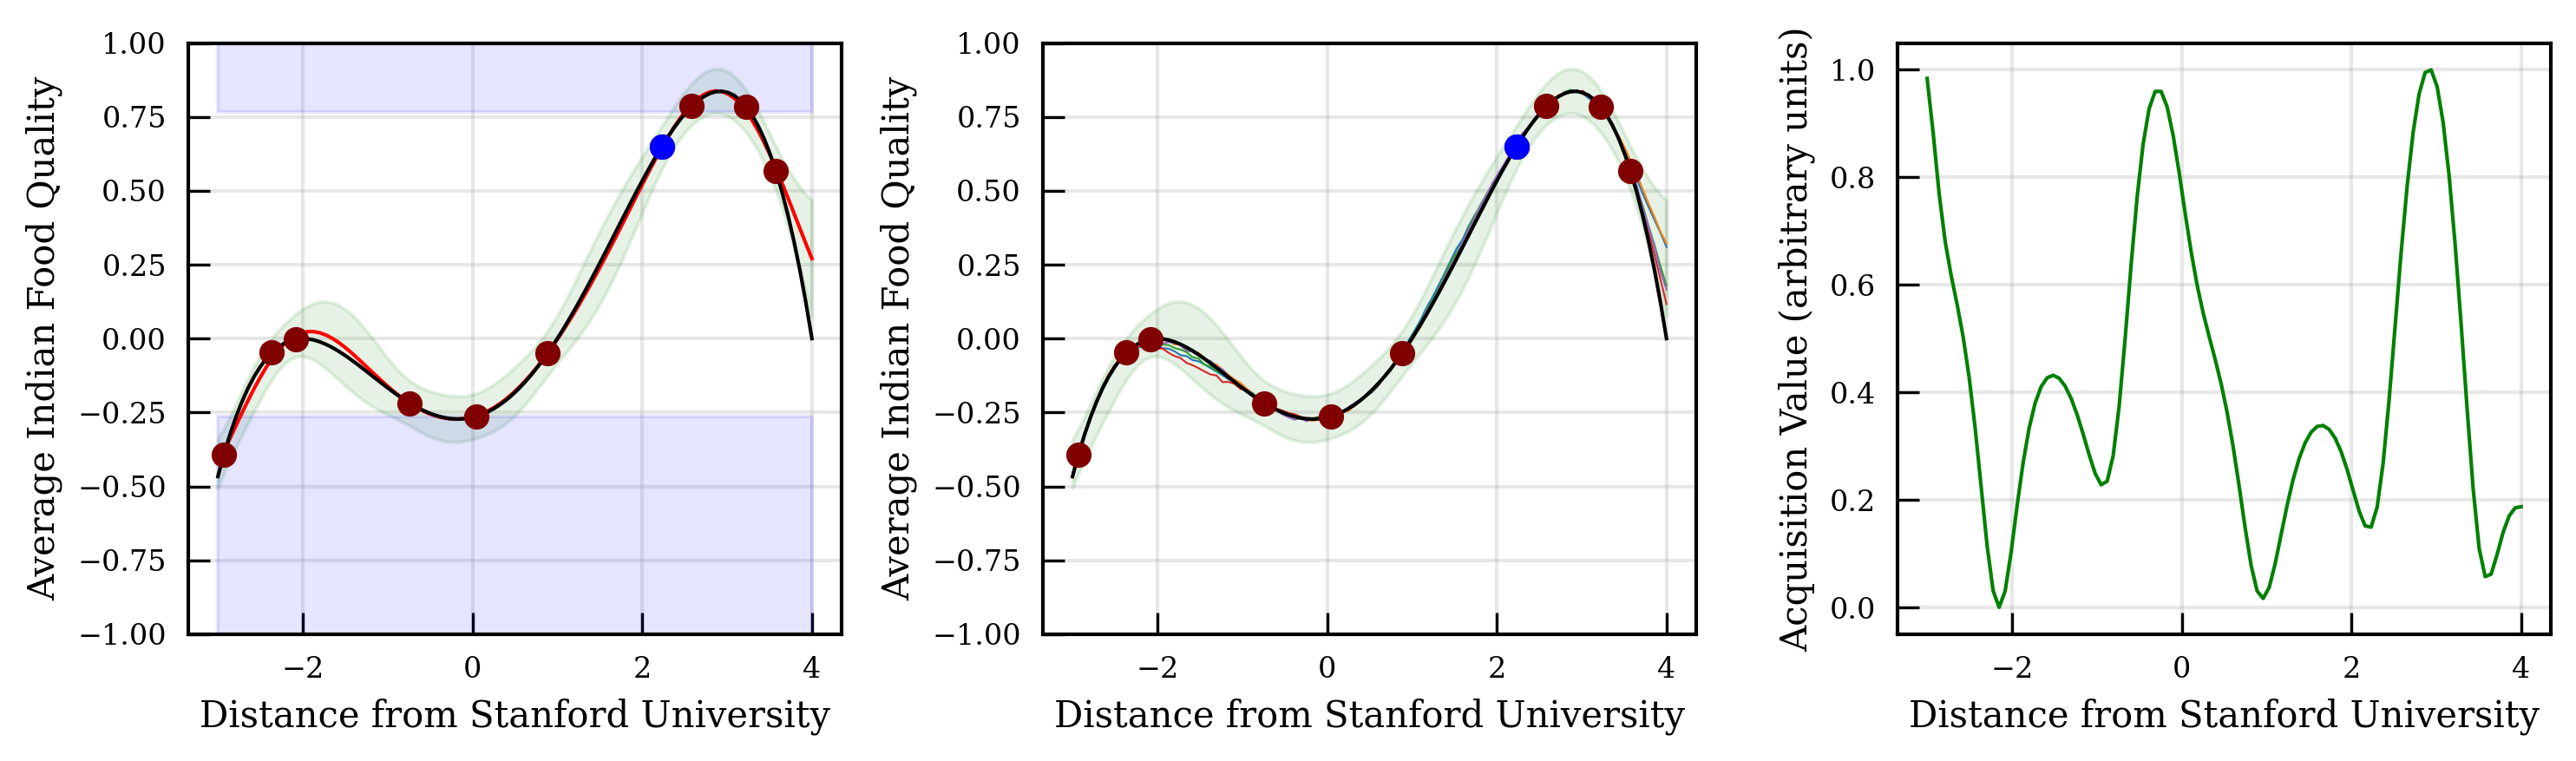

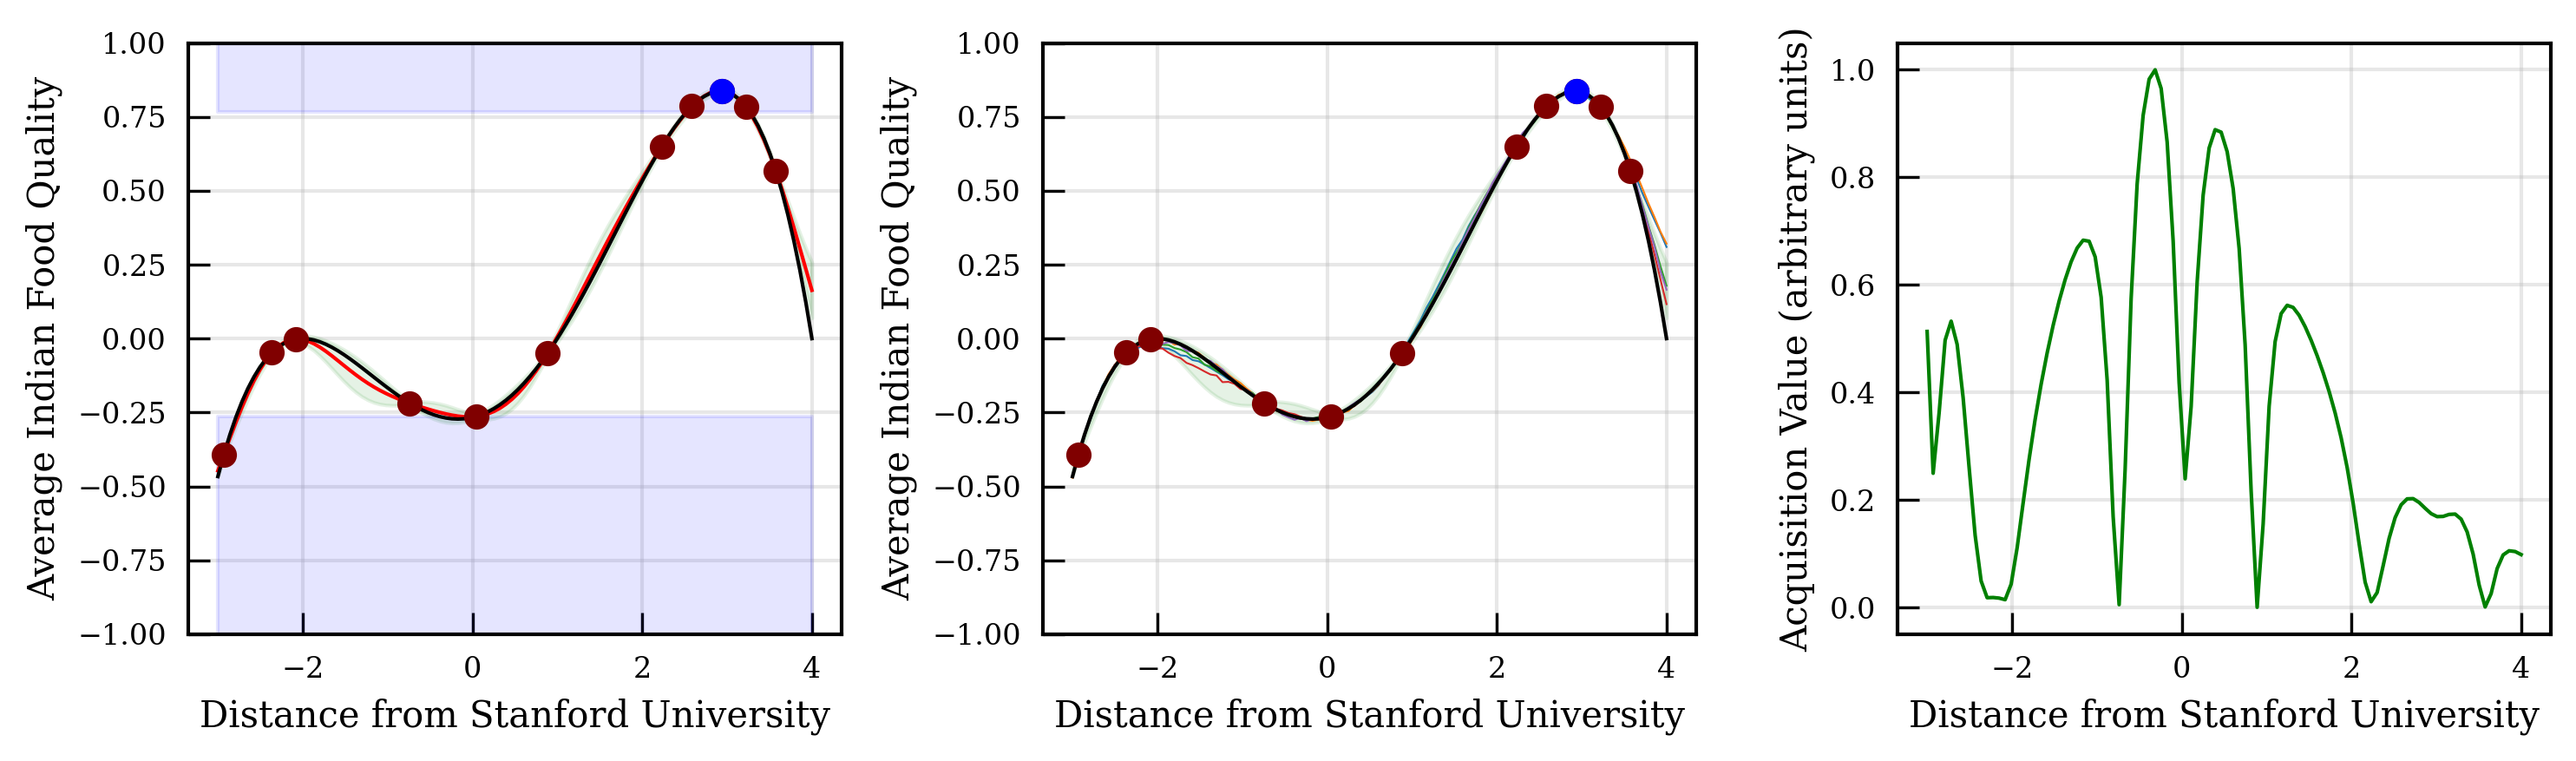

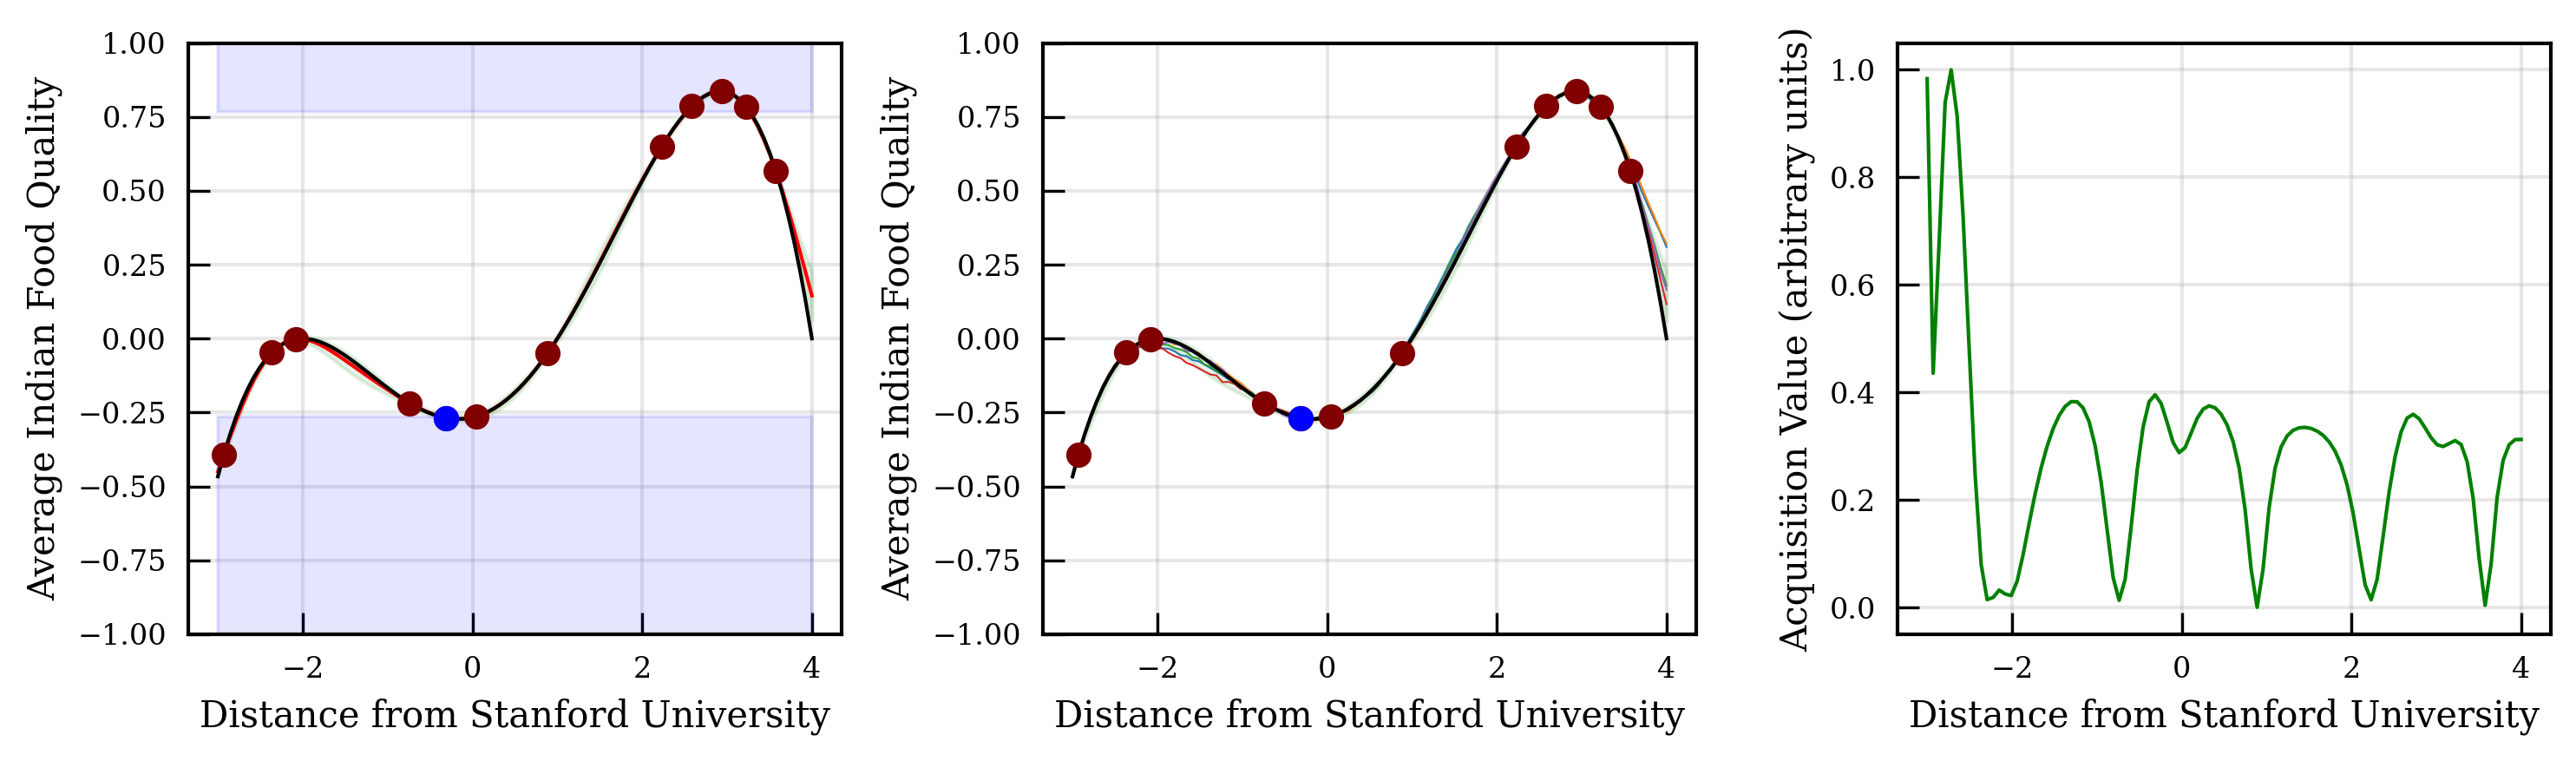

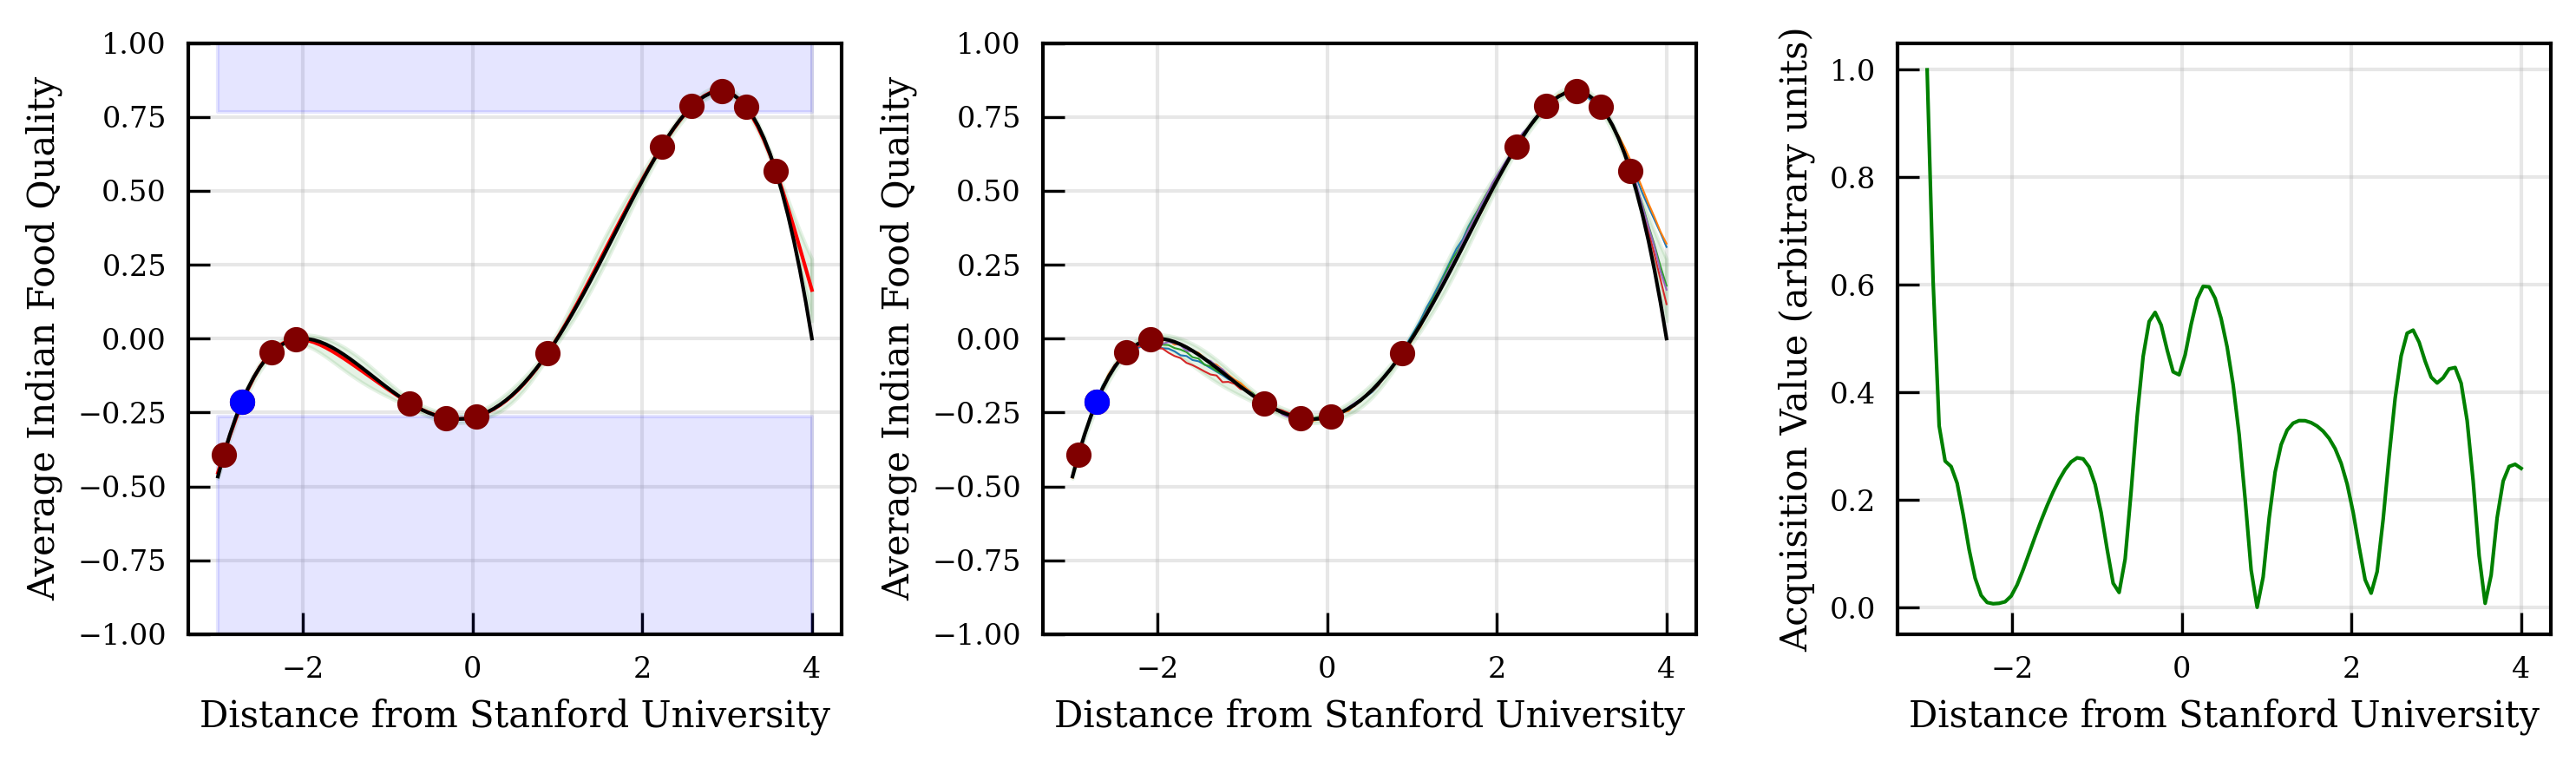

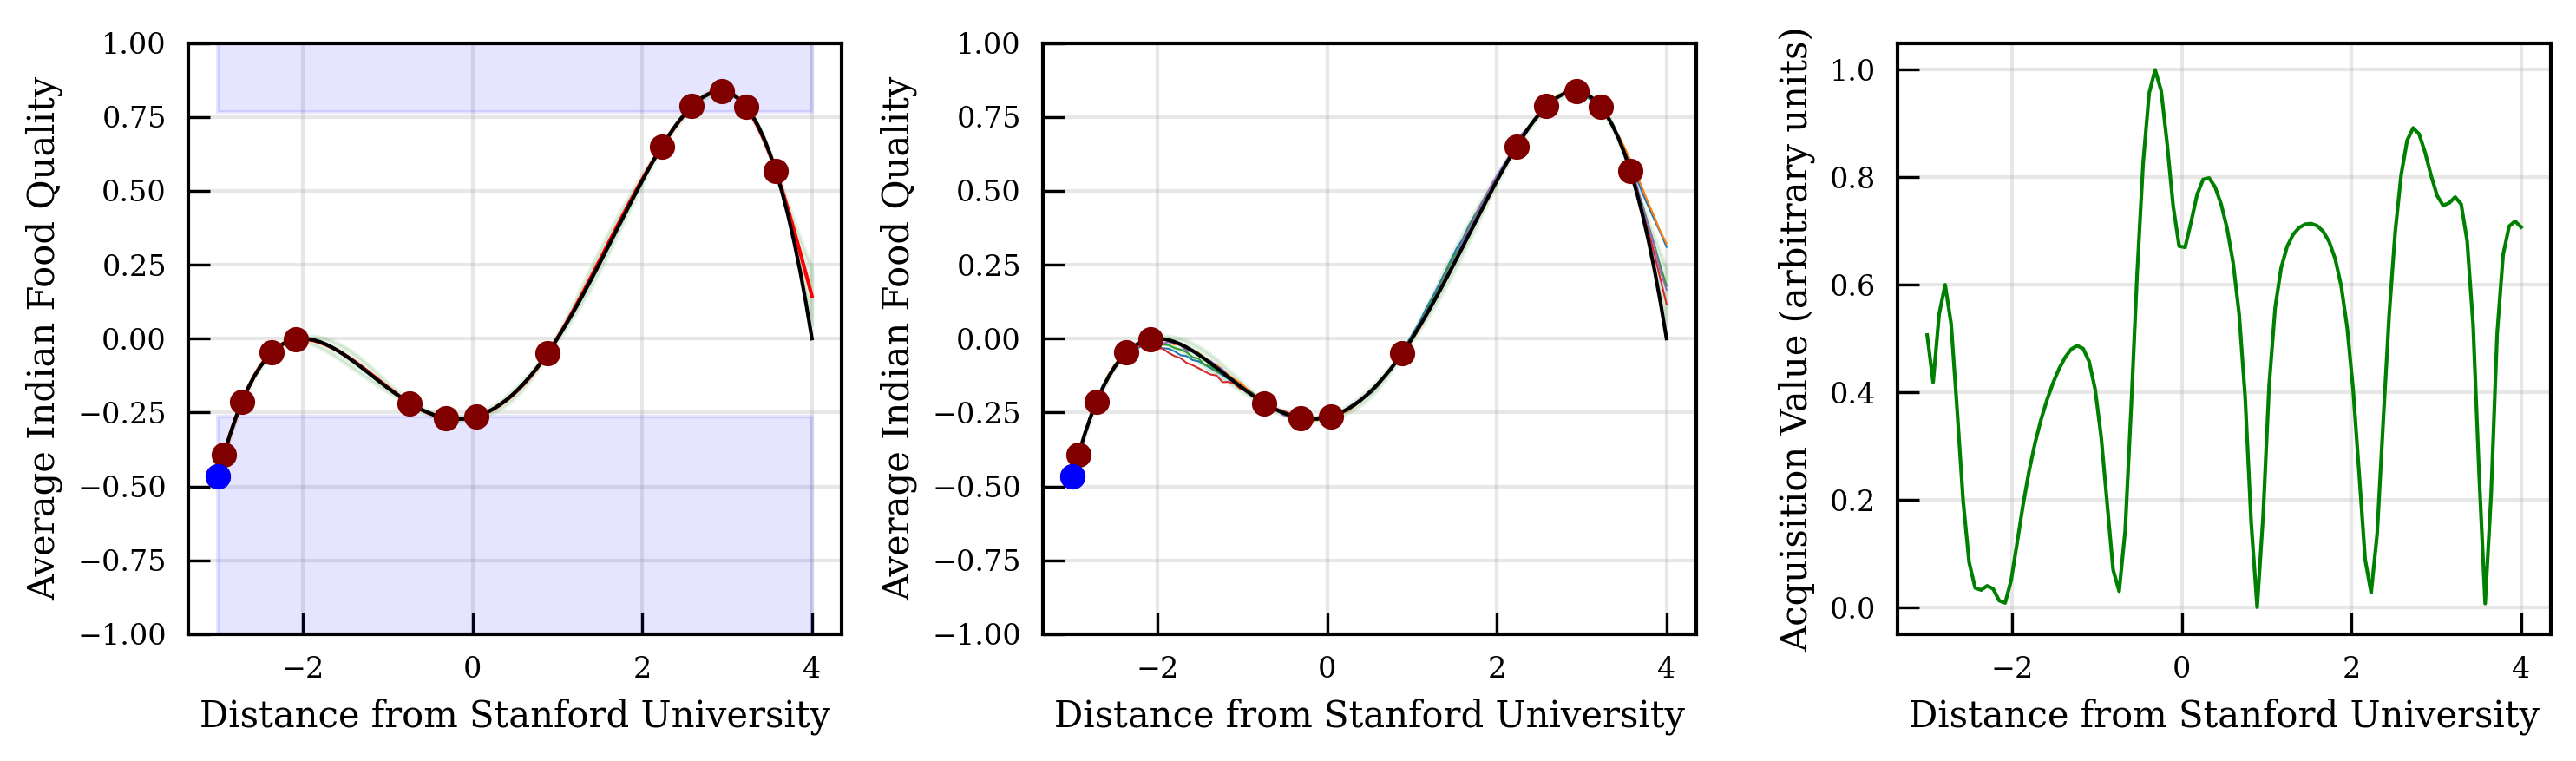

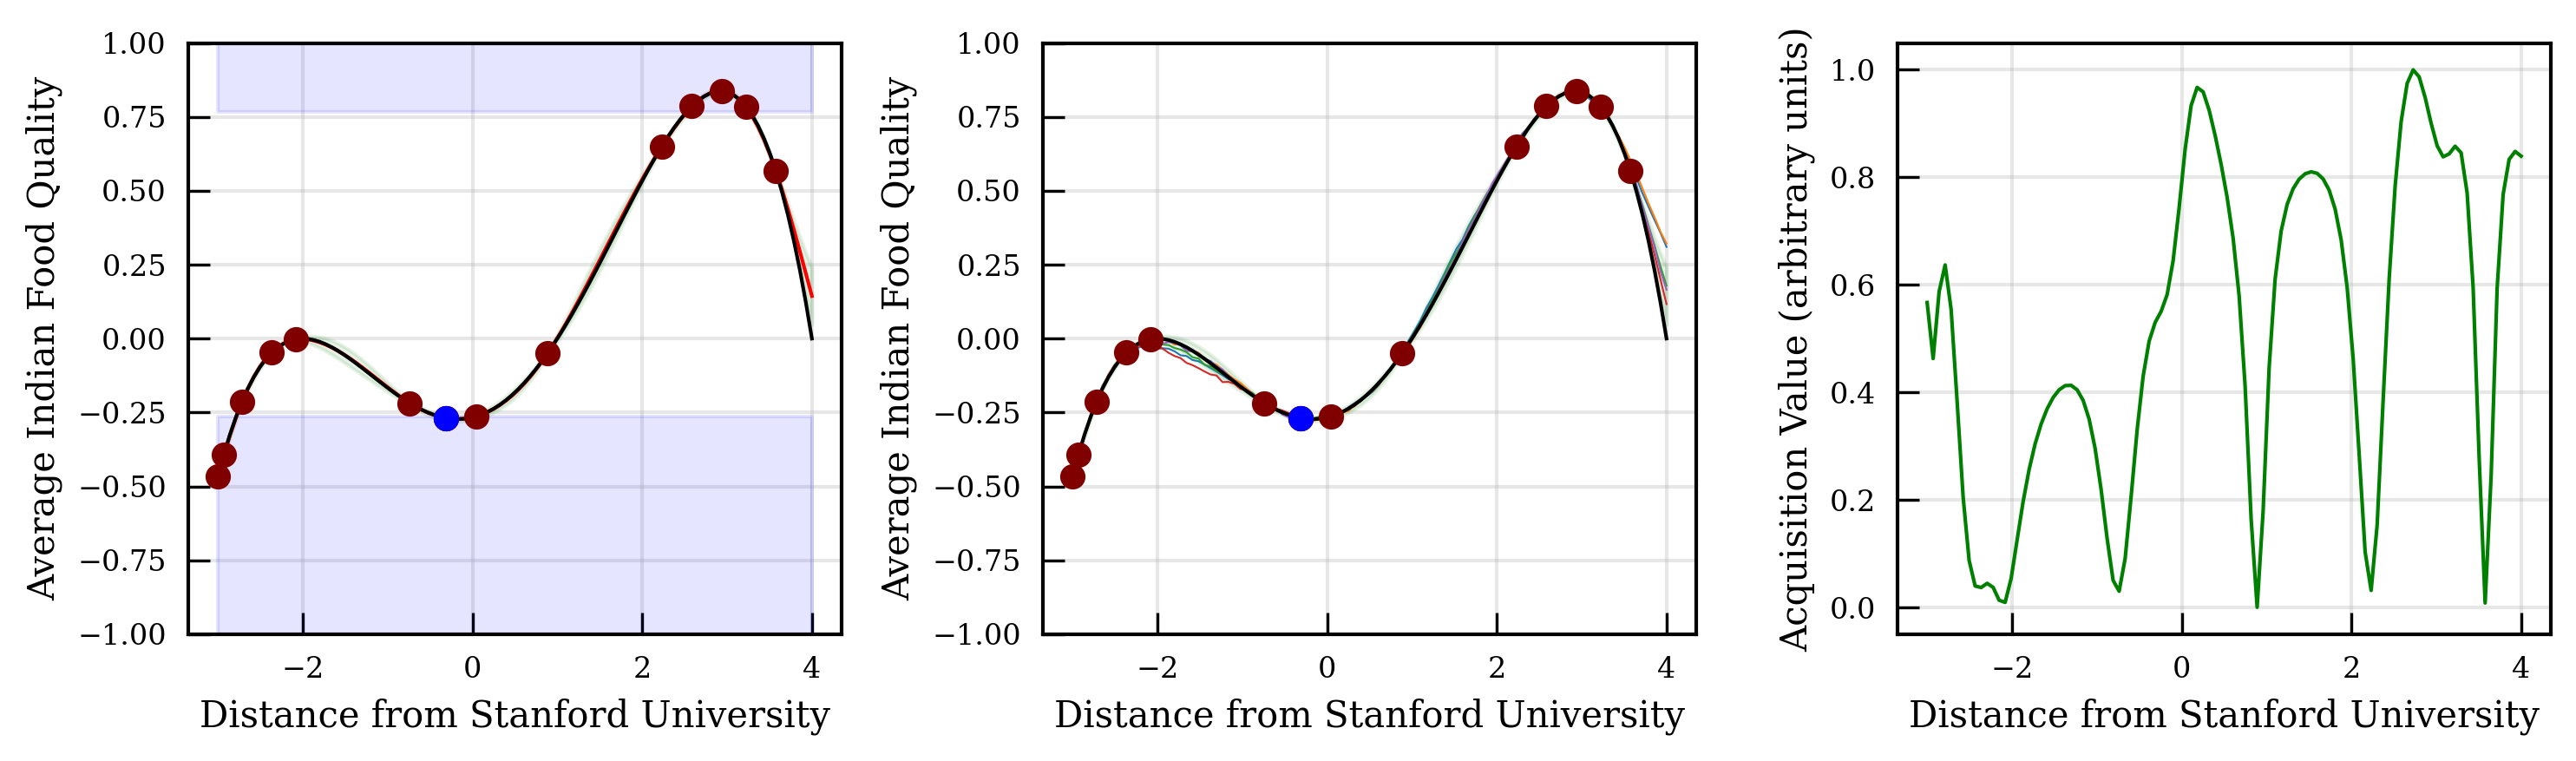

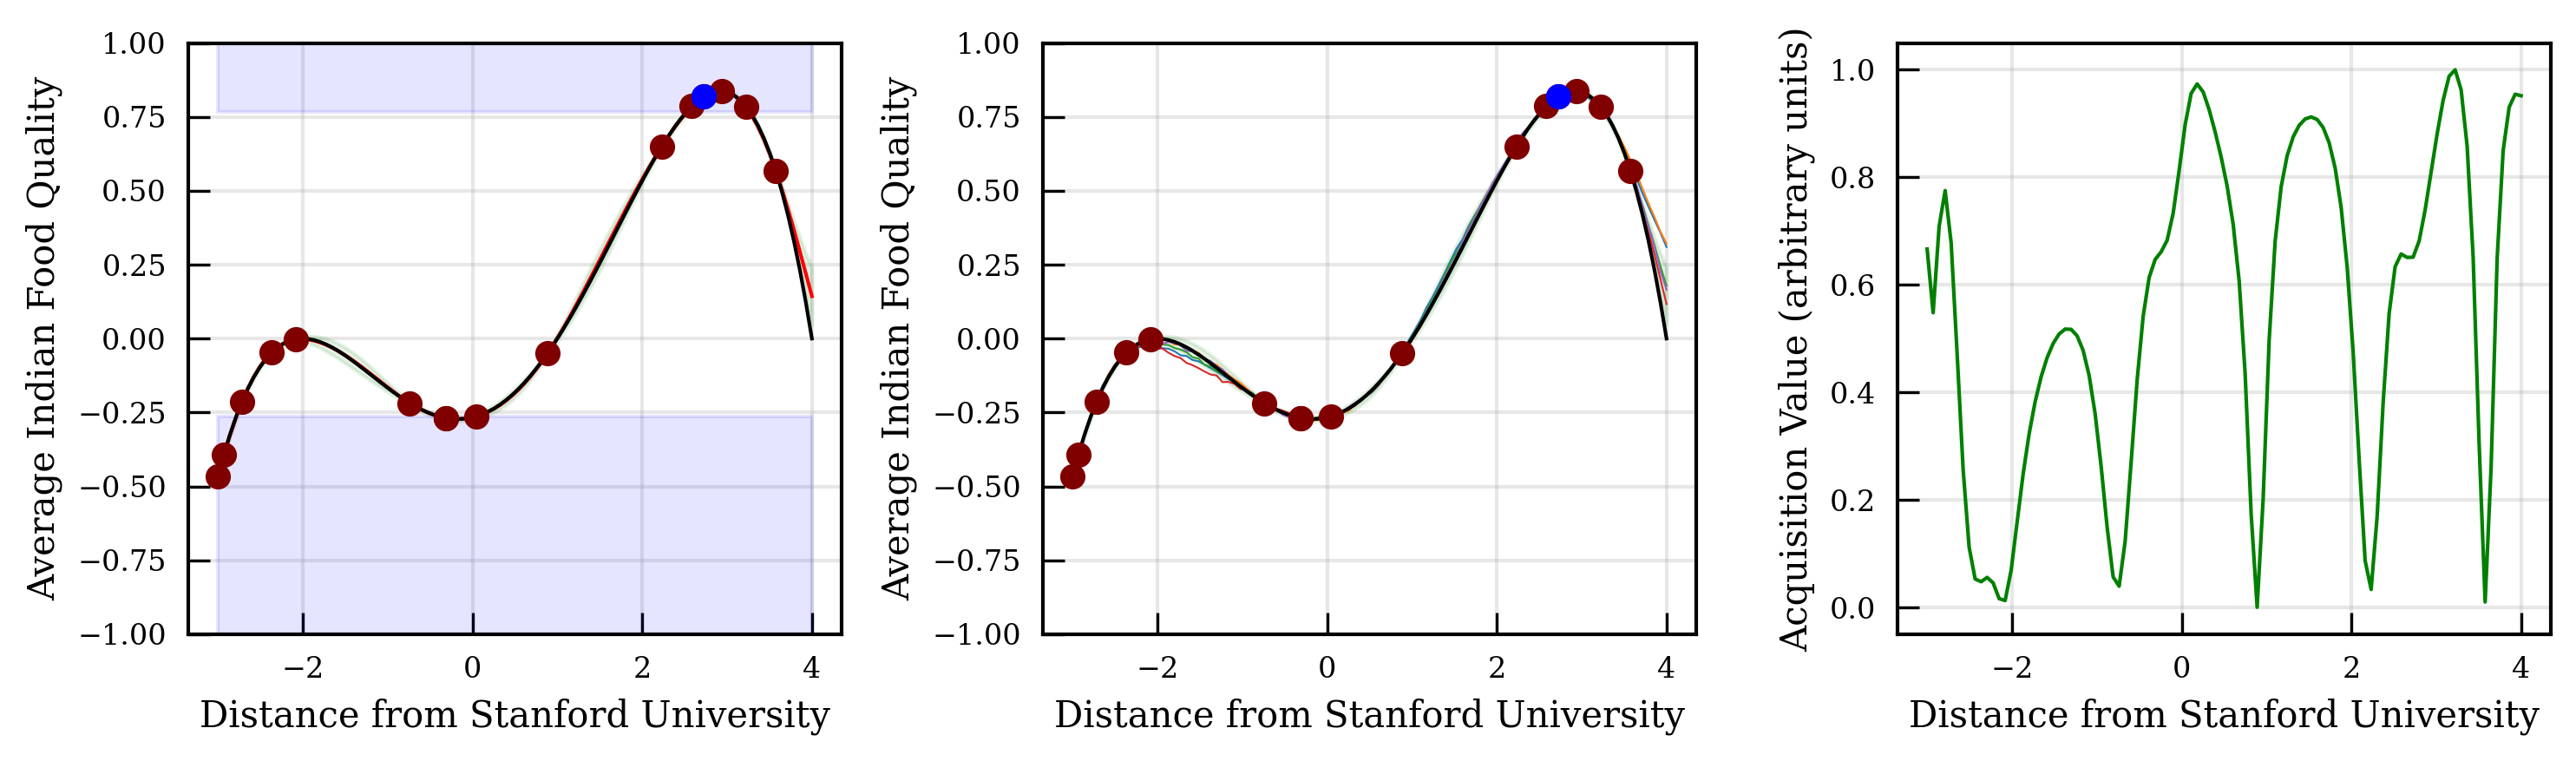

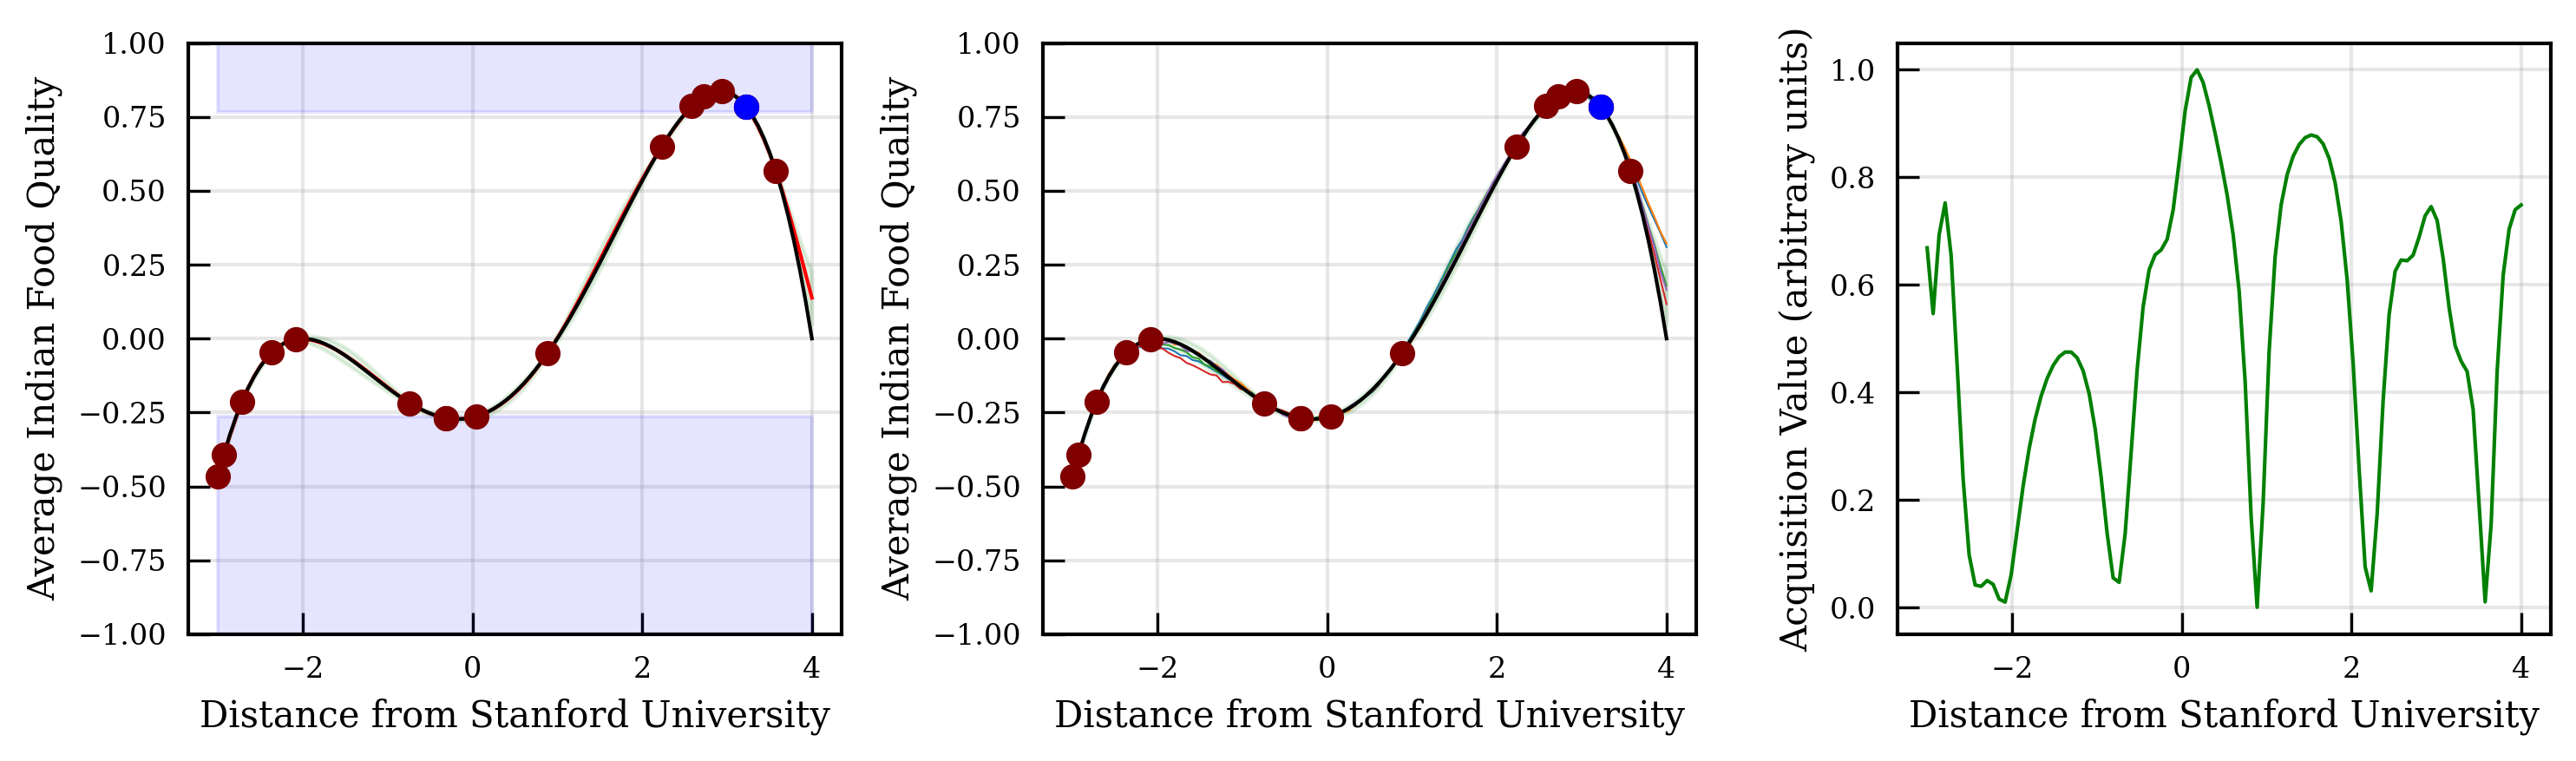

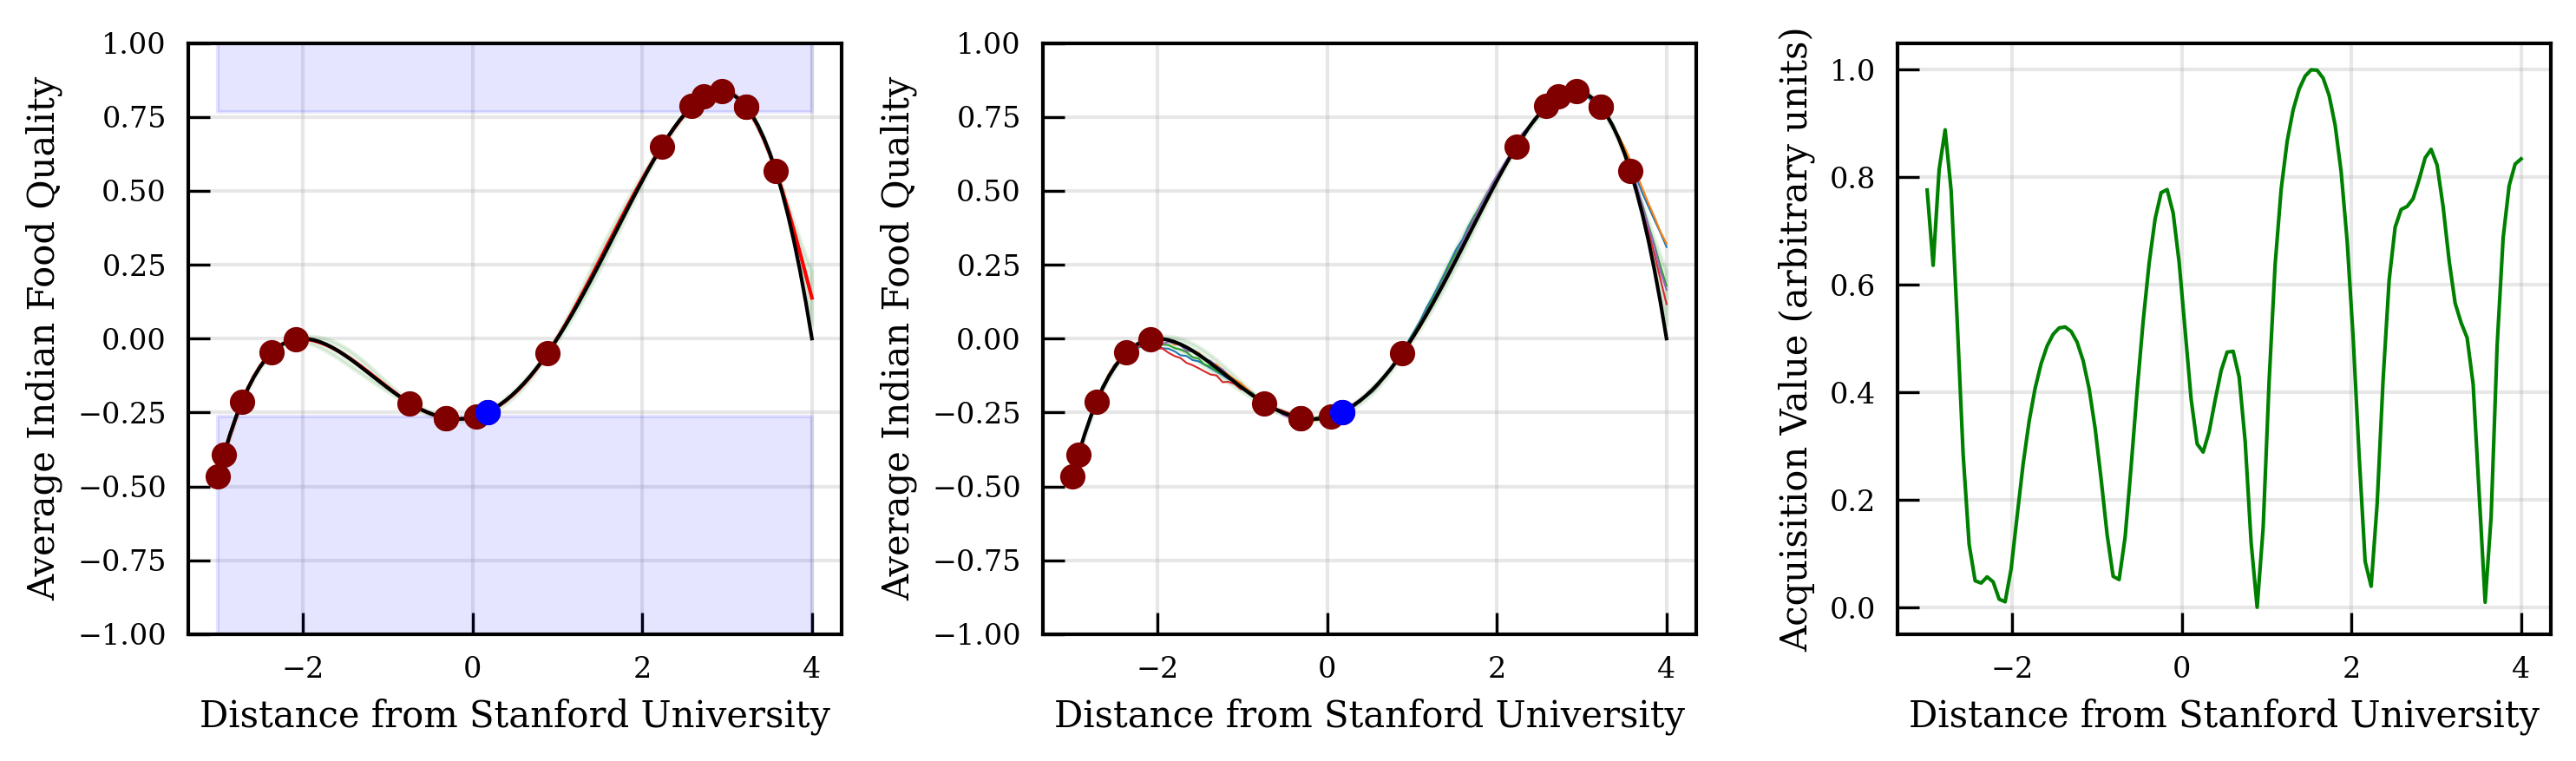

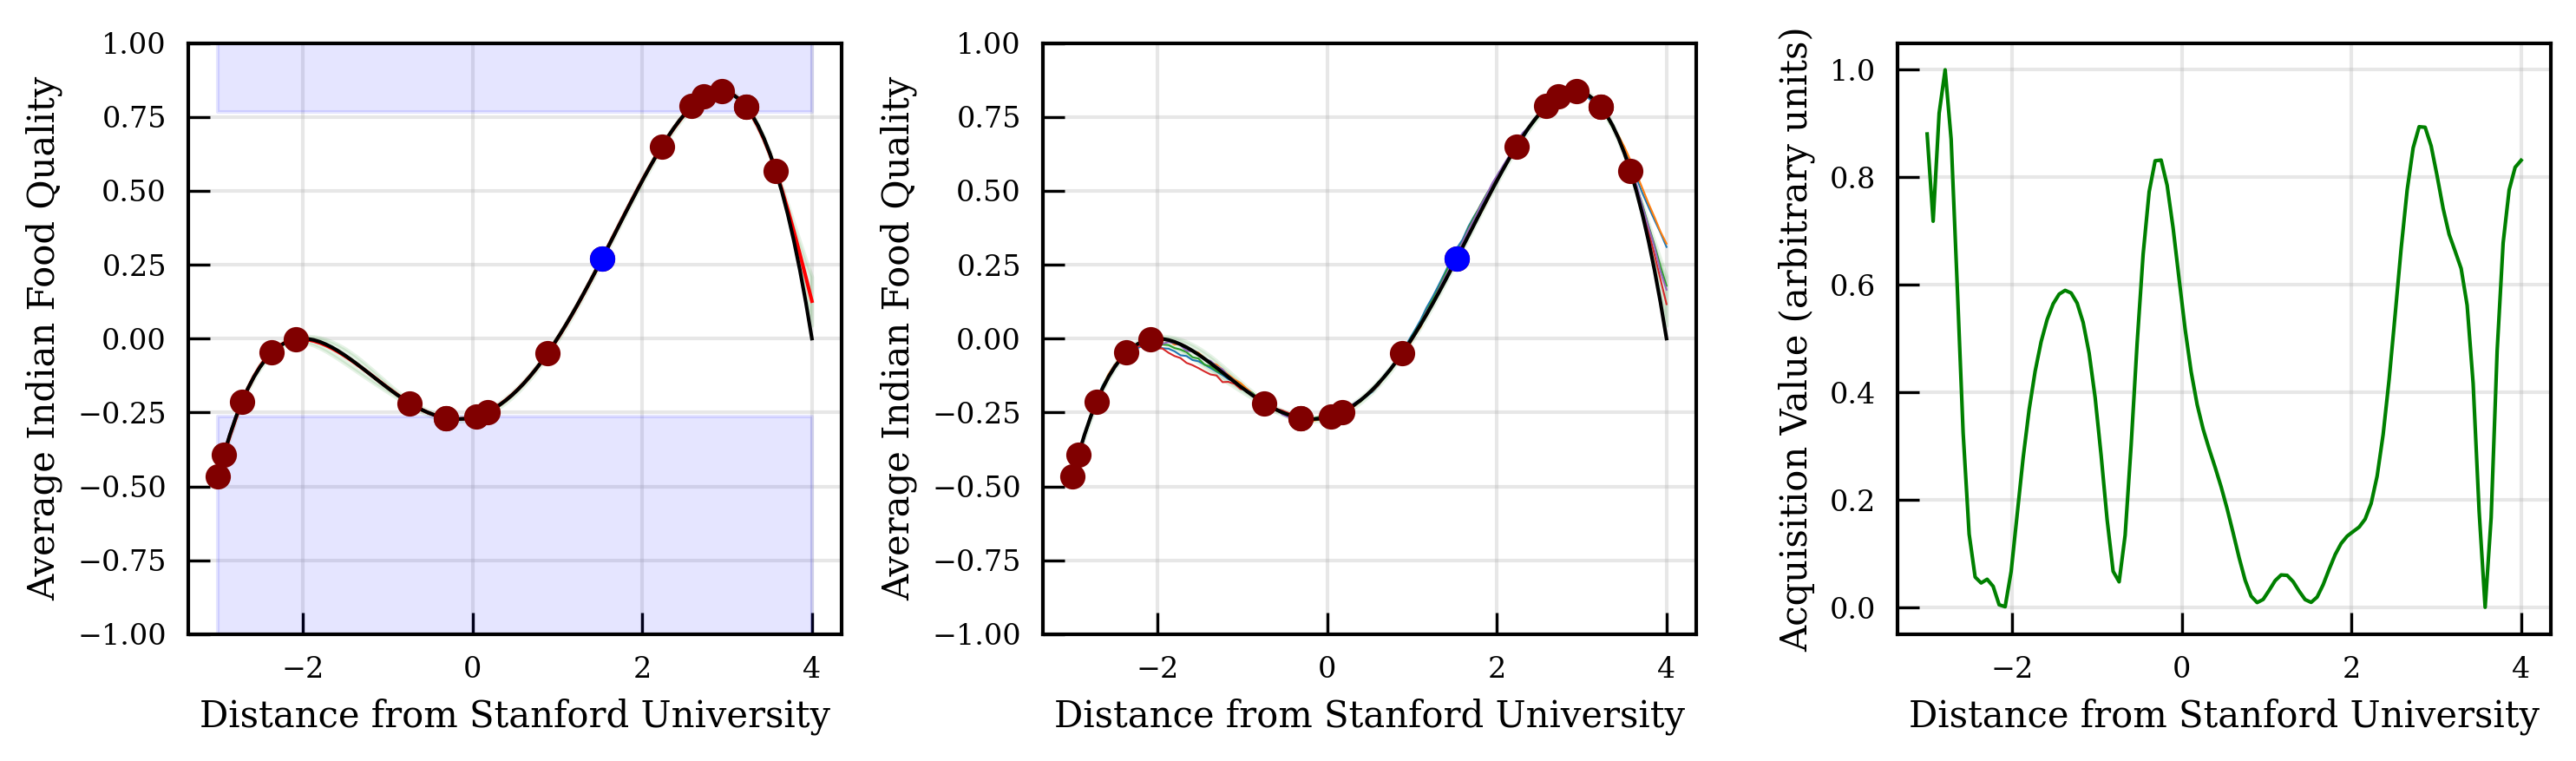

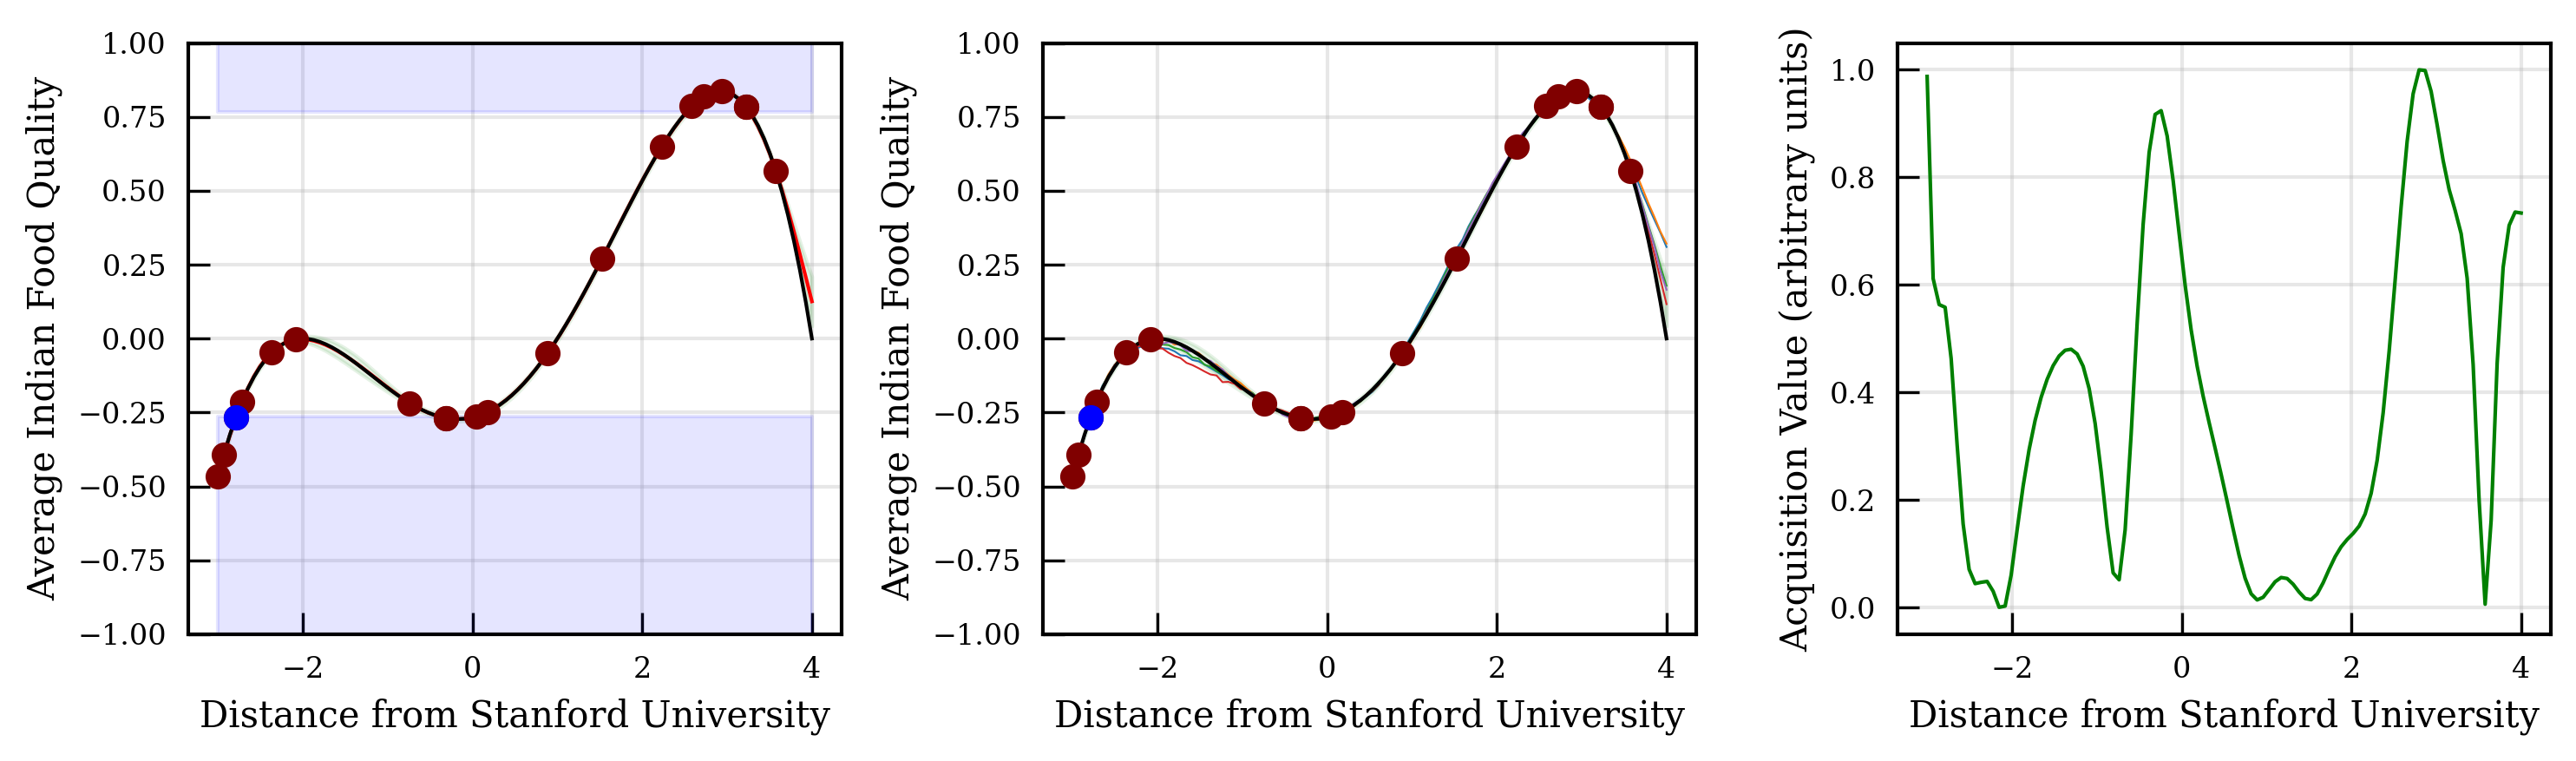

In [245]:
np.random.seed(10)

all_ids = list(np.arange(0, len(fn(x))))
true_target_ids = algo.identify_subspace(fn(x), x)
true_not_target_ids = list(set(all_ids) - set(true_target_ids))

train_indices = list(np.random.choice(all_indices, 3))
x_train = x[train_indices]
y_train = fn(x_train)

kernel = 2.0 * RBF(length_scale=1.0, length_scale_bounds='fixed') + WhiteKernel(0.01)
prevent_requery = False 

std_target = [] 
std_not_target = []

collected_ids = list(train_indices)
strategy = 'infobax_gpr'
k = 1

for i in range(20):
    
    for m in y.shape[1]:
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer = 10)
        acquisition_function, gpr = infobax_gp(x_domain = x, x_train = x_train, y_train = y_train, model = model, algorithm = algo, n_posterior_samples = 20)

    acquisition_function = (acquisition_function - np.min(acquisition_function))/(np.max(acquisition_function) - np.min(acquisition_function))
    
    std_target.append(np.mean(posterior_std[true_target_ids]))
    std_not_target.append(np.mean(posterior_std[true_not_target_ids]))
    
    if prevent_requery:
        acquisition_function = mask * (10 + acquisition_function)
        
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi = 300)
    axes[0].scatter(x_train, y_train, color='maroon', zorder=10)
    axes[0].scatter(x_train[-1], y_train[-1], color='blue', zorder=10)
    axes[0].fill_between(np.squeeze(x), posterior_mean - 2 * posterior_std, posterior_mean + 2 * posterior_std, color='green', alpha=0.1)
    axes[0].plot(x, posterior_mean, color='red')
    axes[0].plot(x, fn(x), color='black')
    axes[0].set_ylabel('Average Indian Food Quality')
    axes[0].set_xlabel('Distance from Stanford University')
    axes[0].set_ylim(-1, 1)
    axes[0].fill_between(np.squeeze(x), np.percentile(fn(x), 90), 1.0, color='blue', alpha=0.1, label='Fill Area')
    axes[0].fill_between(np.squeeze(x), -1.0, np.percentile(fn(x), 10), color='blue', alpha=0.1, label='Fill Area')

    for i in range(5):
        axes[1].plot(x, posterior_samples[:, i], linewidth=0.5)
        
    axes[1].scatter(x_train, y_train, color='maroon', zorder=10)
    axes[1].scatter(x_train[-1], y_train[-1],color='blue', zorder=10)
    axes[1].set_ylabel('Posterior Sample')
    axes[1].plot(x, fn(x), color='black')
    axes[1].set_ylim(-1, 1)
    axes[1].fill_between(np.squeeze(x), posterior_mean - 2 * posterior_std, posterior_mean + 2 * posterior_std, color='green', alpha=0.1)
    axes[1].set_ylabel('Average Indian Food Quality')
    axes[1].set_xlabel('Distance from Stanford University')

    axes[2].plot(x, acquisition_function, color='green')
    axes[2].set_ylabel('Acquisition Value (arbitrary units)')
    axes[2].set_xlabel('Distance from Stanford University')
    
    plt.tight_layout()
    plt.show()
    
    next_id = np.argmax(acquisition_function)
    collected_ids.append(next_id)
    
    x_next = x[next_id]
    y_next = fn(x_next)

    x_train = np.vstack((x_train, x_next))
    y_train = np.vstack((y_train, y_next))

In [267]:
#     if strategy == 'infobax_gpr':
#         acquisition_function, gpr = infobax_gp(x_domain = x, x_train = x_train, y_train = y_train, model = model, algorithm = algo, n_posterior_samples = 20)
#         posterior_mean, posterior_std = get_posterior_mean_and_std(x, gpr)
#     elif strategy == 'US':
#         gpr.fit(x_train, y_train)
#         posterior_mean, posterior_std = get_posterior_mean_and_std(x, gpr)
#         acquisition_function = posterior_std
#     elif strategy == 'UCB':
#         gpr.fit(x_train, y_train)
#         posterior_mean, posterior_std = get_posterior_mean_and_std(x, gpr)
#         acquisition_function = posterior_mean + posterior_std
#     else: 
#         raise NotImplementedError


# np.random.seed(10)

# all_ids = list(np.arange(0, len(fn(x))))
# true_target_ids = algo.identify_subspace(fn(x), x)
# true_not_target_ids = list(set(all_ids) - set(true_target_ids))

# train_indices = list(np.random.choice(all_indices, 3))
# x_train = x[train_indices]
# y_train = fn(x_train)

# kernel = 2.0 * RBF(length_scale=1.0, length_scale_bounds='fixed') + WhiteKernel(0.01)
# prevent_requery = False 

# std_target = [] 
# std_not_target = []

# collected_ids = list(train_indices)
# strategy = 'infobax_gpr'
# k = 1

# for i in range(20):
    
#     for m in y.shape[1]:
#         gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer = 10)
#         acquisition_function, gpr = infobax_gp(x_domain = x, x_train = x_train, y_train = y_train, model = model, algorithm = algo, n_posterior_samples = 20)

#     acquisition_function = (acquisition_function - np.min(acquisition_function))/(np.max(acquisition_function) - np.min(acquisition_function))
    
#     std_target.append(np.mean(posterior_std[true_target_ids]))
#     std_not_target.append(np.mean(posterior_std[true_not_target_ids]))
    
#     if prevent_requery:
#         acquisition_function = mask * (10 + acquisition_function)
        
#     fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi = 300)
#     axes[0].scatter(x_train, y_train, color='maroon', zorder=10)
#     axes[0].scatter(x_train[-1], y_train[-1], color='blue', zorder=10)
#     axes[0].fill_between(np.squeeze(x), posterior_mean - 2 * posterior_std, posterior_mean + 2 * posterior_std, color='green', alpha=0.1)
#     axes[0].plot(x, posterior_mean, color='red')
#     axes[0].plot(x, fn(x), color='black')
#     axes[0].set_ylabel('Average Indian Food Quality')
#     axes[0].set_xlabel('Distance from Stanford University')
#     axes[0].set_ylim(-1, 1)
#     axes[0].fill_between(np.squeeze(x), np.percentile(fn(x), 90), 1.0, color='blue', alpha=0.1, label='Fill Area')
#     axes[0].fill_between(np.squeeze(x), -1.0, np.percentile(fn(x), 10), color='blue', alpha=0.1, label='Fill Area')

#     for i in range(5):
#         axes[1].plot(x, posterior_samples[:, i], linewidth=0.5)
        
#     axes[1].scatter(x_train, y_train, color='maroon', zorder=10)
#     axes[1].scatter(x_train[-1], y_train[-1],color='blue', zorder=10)
#     axes[1].set_ylabel('Posterior Sample')
#     axes[1].plot(x, fn(x), color='black')
#     axes[1].set_ylim(-1, 1)
#     axes[1].fill_between(np.squeeze(x), posterior_mean - 2 * posterior_std, posterior_mean + 2 * posterior_std, color='green', alpha=0.1)
#     axes[1].set_ylabel('Average Indian Food Quality')
#     axes[1].set_xlabel('Distance from Stanford University')

#     axes[2].plot(x, acquisition_function, color='green')
#     axes[2].set_ylabel('Acquisition Value (arbitrary units)')
#     axes[2].set_xlabel('Distance from Stanford University')
    
#     plt.tight_layout()
#     plt.show()
    
#     next_id = np.argmax(acquisition_function)
#     collected_ids.append(next_id)
    
#     x_next = x[next_id]
#     y_next = fn(x_next)

#     x_train = np.vstack((x_train, x_next))
#     y_train = np.vstack((y_train, y_next))

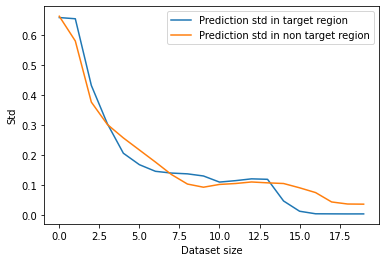

In [75]:
plt.plot(std_target, label = 'Prediction std in target region')
plt.plot(std_not_target, label = 'Prediction std in non target region')
plt.xlabel('Dataset size')
plt.ylabel('Std')
plt.legend()
plt.show()

In [288]:
from sklearn.multioutput import MultiOutputRegressor

class MultioutputGPR:
    def __init__(self, kernel_list):
        self.models = [GaussianProcessRegressor(kernel=kernel_list[i]) for i in range(len(kernel_list))]

    def fit(self, X, y):
        for i, model in enumerate(self.models):
            model.fit(X, y[:, i])

    def predict(self, X):
        predictions = []
        for model in self.models:
            predictions.append(model.predict(X, return_std = True))
        return predictions

custom_gp_regressor = MultioutputGPR(kernel_list=[RBF(length_scale=1), RBF(length_scale=1)])
multioutput_gpr = MultiOutputRegressor(estimator=[gpr1, gpr2])

custom_gp_regressor.fit(X, y)
X_new = np.linspace(0, 1, 100).reshape(-1, 1)
y_pred = custom_gp_regressor.predict(X_new)

(array([ 0.00000000e+000,  3.03130429e-151,  3.40722863e-029,
        0.00000000e+000, -1.14906016e-031,  2.09026969e-057,
        9.59781107e-150,  4.08465841e-077,  9.95311771e-035,
        1.03710605e-001, -1.61214267e-234,  1.66363579e-119,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        6.08944893e-232,  9.03533235e-116,  9.88131292e-324,
        4.58587667e-023,  3.82745268e-052,  0.00000000e+000,
        5.94844258e-017,  1.61838452e-020,  5.67206638e-151,
        2.27396937e-130,  1.07306043e-031,  0.00000000e+000,
        0.00000000e+000,  2.34301795e-030,  3.14732374e-118,
        1.07266381e-056,  3.10469192e-005,  2.59118652e-048,
        3.00540598e-002,  1.21637521e-282,  2.85576682e-046,
        1.35136367e-027,  1.04021237e-010,  7.86192480e-173,
        0.00000000e+000,  3.39534576e-219,  0.00000000e+000,
        0.00000000e+000,  7.32321521e-015,  1.20285281e-146,
        5.77936888e-277,  2.91737665e-005,  0.00000000e+000,
        3.03928670e-012

In [277]:
custom_gp_regressor2 = deepcopy(custom_gp_regressor)

In [287]:
custom_gp_regressor2.predict(x)

array([[ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0

In [ ]:
def get_posterior_mean_and_std(x, model):
    posterior_mean, posterior_std = np.squeeze(model.predict(x, return_std = True))
    return posterior_mean, posterior_std